# SpaceNet Model - Classificação de Imagens Astronômicas usando CNNs e Optuna

Este notebook guia você através do processo de criação, treinamento e avaliação de um modelo de classificação de imagens astronômicas usando Redes Neurais Convolucionais (CNNs) com PyTorch. Também utilizaremos o Optuna para otimização de hiperparâmetros e o TQDM para barras de progresso.

---
# 1. Importação de Bibliotecas e Configurações Iniciais

---

### **Bibliotecas para Avaliação de Modelos**
- **`from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score`**
  - Contém funções úteis para avaliar modelos de aprendizado de máquina, como métricas de precisão, recall, F1-score e matriz de confusão. Ajuda na análise da performance do modelo.

---

### **Bibliotecas do PyTorch**
- **`import torch`**
  - Framework de deep learning utilizado para criar e treinar modelos de redes neurais.

- **`import torch.nn as nn`**
  - Submódulo do PyTorch para implementar arquiteturas de redes neurais.

- **`import torch.optim as optim`**
  - Submódulo para otimização, com algoritmos como SGD, Adam, entre outros.

- **`from torchvision import datasets, transforms, models`**
  - Oferece datasets, transformações de dados e modelos pré-treinados para facilitar o desenvolvimento de modelos de visão computacional.

- **`from torch.utils.data import DataLoader, random_split`**
  - Utilizado para carregar e dividir datasets de forma eficiente durante o treinamento e validação.

---

### **Biblioteca para Otimização de Hiperparâmetros**
- **`import optuna`**
  - Framework para otimização de hiperparâmetros, útil para encontrar as melhores combinações de parâmetros para modelos de aprendizado de máquina.

---

### **Manipulação e Tratamento de Imagens**
- **`from PIL import Image, UnidentifiedImageError`**
  - Biblioteca para abrir, manipular e salvar imagens em diversos formatos. Permite lidar com erros de arquivos de imagem não identificados.

---

### **Execução Paralela e Progress Bar**
- **`from concurrent.futures import ThreadPoolExecutor, as_completed`**
  - Permite a execução paralela de tarefas, otimizando o desempenho ao lidar com múltiplas tarefas simultâneas.

- **`from tqdm import tqdm`**
  - Exibe uma barra de progresso para loops, útil para acompanhar processos demorados.

---

### **Manipulação de Arquivos e Sistemas**
- **`import subprocess`**
  - Executa comandos do sistema operacional diretamente pelo Python.

- **`import zipfile`**
  - Permite trabalhar com arquivos compactados no formato ZIP, incluindo leitura e extração.

- **`import os`**
  - Utilizado para interagir com o sistema operacional, como manipular diretórios e arquivos.

---

### **Manipulação de Dados**
- **`import collections`**
  - Fornece estruturas de dados especializadas como `Counter` e `defaultdict` para facilitar a manipulação de coleções.

---

### **Visualização de Dados**
- **`import matplotlib.pyplot as plt`**
  - Biblioteca para criar gráficos estáticos, personalizáveis e de alta qualidade.

- **`import seaborn as sns`**
  - Extensão do Matplotlib para criar visualizações estatísticas com design mais sofisticado.

---

### **Avisos e Configurações**
- **`import warnings`**
  - Permite o controle e a supressão de mensagens de aviso geradas pelo código.

---

In [1]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import optuna
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
import zipfile
import warnings
from PIL import Image, UnidentifiedImageError
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import os
import collections
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms



# Configurações gerais
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)
print("[INFO] Bibliotecas importadas com sucesso.")

[INFO] Bibliotecas importadas com sucesso.


---

## 2. Verificação da Disponibilidade da GPU

Verificamos se o PyTorch reconhece a GPU disponível, o que pode acelerar significativamente o treinamento do modelo.

---
### **Verificar Versão do PyTorch e Disponibilidade de CUDA**

In [21]:
# Verificar se o PyTorch reconhece a GPU
print(f"Versão do PyTorch: {torch.__version__}")
print(f"CUDA disponível: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Número de GPUs disponíveis: {torch.cuda.device_count()}")
    print(f"Nome da GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA não está disponível. A GPU não será usada.")
# Definir o dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo em uso: {device}")

Versão do PyTorch: 2.5.1+cu124
CUDA disponível: True
Número de GPUs disponíveis: 1
Nome da GPU: NVIDIA GeForce RTX 4060 Laptop GPU
Dispositivo em uso: cuda


- **`torch.__version__`**: Exibe a versão do PyTorch instalada.
- **`torch.cuda.is_available()`**: Verifica se o PyTorch consegue acessar a API CUDA, indicando se uma GPU compatível está disponível no sistema.
- **`torch.cuda.device_count()`**: Retorna o número de GPUs disponíveis no sistema.
- **`torch.cuda.get_device_name(0)`**: Exibe o nome da primeira GPU detectada (índice 0).
- **`torch.device`**: Define o dispositivo de computação como `cuda` (GPU) ou `cpu`, dependendo da disponibilidade de uma GPU.
- O dispositivo configurado será exibido para garantir que o ambiente está correto.

Se CUDA não estiver disponível, o código informa que a GPU não será usada.

---

## 3. Funções Auxiliares

Definimos funções auxiliares que serão usadas ao longo do projeto.

### 3.1. Função para Obter o Número Máximo de Threads

Essa função retorna o número máximo de threads que a CPU pode utilizar, o que é útil para operações de processamento paralelo.

---

In [22]:
def get_max_threads():
    """Retorna o número máximo de threads que a CPU pode usar."""
    try:
        max_threads = os.cpu_count() or 1
        print(f"[INFO] Número máximo de threads disponíveis: {max_threads}")
        return max_threads
    except Exception as e:
        print(f"[ERRO] Falha ao obter o número de threads: {e}")
        return 1

# Obter o número máximo de threads
max_threads = get_max_threads()

[INFO] Número máximo de threads disponíveis: 24


### 3.2. Funções para Carregamento e Verificação de Imagens

Essas funções auxiliam no carregamento seguro das imagens e na verificação de arquivos válidos.

---
## **Resumo de Uso**
### Exemplo de Fluxo
1. Verificar se um arquivo possui uma extensão válida usando `is_valid_file`.
2. Carregar e validar o arquivo com `is_image_valid`.

### Saída Esperada
- **Se a imagem for válida**:
  ```plaintext
  [INFO] Imagem carregada com sucesso.
  ```
- **Se a imagem for inválida**:
  ```plaintext
  [ERRO] Não foi possível carregar a imagem: <caminho> - <mensagem do erro>
  ```

---

## **Função `pil_loader`**
### Descrição
Carrega uma imagem a partir de um caminho fornecido utilizando **Pillow** e converte para o modo RGB.
### Explicação
1. **Abrir o arquivo no modo binário (`'rb'`)**:
   ```python
   with open(path, 'rb') as f:
   ```
   Garante que a imagem seja lida no formato apropriado para processamento.

2. **Carregar a imagem com Pillow**:
   ```python
   img = Image.open(f)
   img.load()
   return img.convert('RGB')
   ```
   - **`Image.open(f)`**: Abre o arquivo como uma imagem.
   - **`img.load()`**: Carrega a imagem para memória.
   - **`img.convert('RGB')`**: Converte a imagem para o formato RGB.

3. **Tratamento de Exceções**:
   ```python
   except (UnidentifiedImageError, OSError) as e:
   ```
   - **`UnidentifiedImageError`**: Erro levantado quando o arquivo não é uma imagem válida.
   - **`OSError`**: Erro levantado para problemas relacionados ao sistema operacional (ex.: arquivo não encontrado).

---

In [23]:
def pil_loader(path):
    """Carrega uma imagem usando PIL."""
    try:
        with open(path, 'rb') as f:
            img = Image.open(f)
            img.load()
            return img.convert('RGB')
    except (UnidentifiedImageError, OSError) as e:
        print(f"[ERRO] Não foi possível carregar a imagem: {path} - {e}")
        return None

## **Função `is_valid_file`**
### Descrição
Verifica se o arquivo possui uma extensão válida para imagens.
### Explicação
1. **`filename.lower()`**: Converte o nome do arquivo para minúsculas para evitar problemas com diferenciação de maiúsculas/minúsculas.
2. **`endswith`**: Verifica se o nome do arquivo termina com uma das extensões indicadas (`.jpg`, `.jpeg`, `.png`).

---

In [24]:
def is_valid_file(filename):
    """Verifica se o arquivo é uma imagem válida."""
    return filename.lower().endswith(('.jpg', '.jpeg', '.png'))

## **Função `is_image_valid`**
### Descrição
Verifica se a imagem em um caminho específico é válida, utilizando a função `pil_loader`.
### Explicação
1. **Carrega a imagem com `pil_loader`**:
   ```python
   img = pil_loader(path)
   return img is not None
   ```
   Retorna `True` se a imagem foi carregada com sucesso, ou `False` caso contrário.

2. **Tratamento de Exceções**:
   ```python
   except:
       return False
   ```
   Captura quaisquer erros e retorna `False` se a imagem não puder ser validada.

---


In [25]:
def is_image_valid(path):
    """Verifica se a imagem no caminho fornecido é válida."""
    try:
        img = pil_loader(path)
        return img is not None
    except:
        return False

---

## 4. Transformações de Imagem

Definimos as transformações que serão aplicadas às imagens antes de serem inseridas no modelo. Isso inclui redimensionamento, conversão para tensor e normalização.

---

# Definição de Transformações de Imagens com `torchvision.transforms`

Este código define uma sequência de transformações para imagens utilizando o módulo **`torchvision.transforms`**.

---

## **Explicação do Código**

### **`transforms.Compose`**
- Combina múltiplas transformações em sequência. 
- Cada transformação é aplicada na ordem em que foi especificada.

---

### **Lista de Transformações**

1. **`transforms.Resize((150, 150))`**
   - Redimensiona a imagem para as dimensões especificadas (150x150 pixels).
   - Útil para padronizar o tamanho de entrada das imagens em redes neurais.

2. **`transforms.ToTensor()`**
   - Converte a imagem em um tensor PyTorch.
   - Normaliza os valores dos pixels para o intervalo `[0, 1]`.

3. **`transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])`**
   - Normaliza os tensores de imagem com médias (`mean`) e desvios padrão (`std`) fornecidos.
   - As médias e desvios padrão usados são valores comuns para normalização de imagens no **ImageNet**:
     - **Médias**: `[0.485, 0.456, 0.406]` (para os canais R, G, B).
     - **Desvios padrão**: `[0.229, 0.224, 0.225]` (para os canais R, G, B).

---

## **Mensagem de Informação**
```python
print("[INFO] Transformações de imagem definidas.")
```
- Informa ao usuário que as transformações foram configuradas corretamente.

---

## **Resumo**
### Transformações Aplicadas
1. **Redimensionar** a imagem para 150x150 pixels.
2. **Converter** para tensor PyTorch.
3. **Normalizar** os valores dos canais RGB com médias e desvios padrão pré-definidos.

In [26]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
print("[INFO] Transformações de imagem definidas.")

[INFO] Transformações de imagem definidas.


---

## 5. Download e Preparação do Dataset

# Função para Download e Extração de Dataset com Kaggle

Esta função baixa um dataset hospedado no Kaggle, o extrai para um diretório local e remove o arquivo zip após a extração.

---

## **Explicação do Código**

### **1. Verificar Diretório**
```python
os.makedirs(dataset_path, exist_ok=True)
```
- **`os.makedirs`**: Cria o diretório especificado (`dataset_path`). 
- **`exist_ok=True`**: Evita erros se o diretório já existir.

---

### **2. Verificar Dataset Localmente**
```python
if not os.listdir(dataset_path):
```
- **`os.listdir(dataset_path)`**: Lista os arquivos no diretório.
- Se o diretório estiver vazio, inicia o processo de download.

---

### **3. Download do Dataset**
```python
result = subprocess.run(
    ["kaggle", "datasets", "download", "-d", "razaimam45/spacenet-an-optimally-distributed-astronomy-data",
     "-p", dataset_path],
    text=True, capture_output=True
)
```
- **`subprocess.run`**: Executa o comando CLI para baixar o dataset com o Kaggle API:
  - **`kaggle datasets download`**: Comando para download.
  - **`-d`**: Especifica o identificador do dataset no Kaggle.
  - **`-p`**: Define o diretório de destino.

---

### **4. Verificar Erros no Download**
```python
if result.stderr:
    print("[ERRO]", result.stderr)
```
- Exibe mensagens de erro geradas durante o download.

---

### **5. Extração do Arquivo Zip**
```python
zip_file_path = os.path.join(dataset_path, "spacenet-an-optimally-distributed-astronomy-data.zip")

if os.path.exists(zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_path)
    os.remove(zip_file_path)
    print("[INFO] Dataset extraído e arquivo zip removido.")
else:
    print("[ERRO] Arquivo zip não encontrado após o download.")
```
- **`os.path.exists`**: Verifica se o arquivo zip está presente.
- **`zipfile.ZipFile`**: Abre e extrai o conteúdo do arquivo zip.
- **`os.remove`**: Remove o arquivo zip após a extração.

---

### **6. Mensagem Caso o Dataset Já Esteja Local**
```python
else:
    print("[INFO] Dataset já encontrado localmente.")
```
- Exibe uma mensagem informando que o dataset já está no diretório.

---

## **Resumo**

### **Objetivo**
Baixar automaticamente um dataset do Kaggle, extrair os arquivos e organizar o diretório local para uso.

### **Fluxo**
1. Verifica se o diretório do dataset existe e está preenchido.
2. Realiza o download via API do Kaggle, se necessário.
3. Extrai o conteúdo do arquivo zip e remove o arquivo compactado.
4. Exibe mensagens de status durante o processo.

### **Dependências**
- API do Kaggle instalada e configurada.
- Token de autenticação disponível.

---

## **Saída Esperada**
1. Caso o dataset seja baixado:
   ```plaintext
   [INFO] Iniciando o carregamento do dataset...
   [INFO] Diretório 'data/' criado/verificado.
   [INFO] Dataset não encontrado localmente. Realizando download...
   [INFO] Extraindo o arquivo zip...
   [INFO] Dataset extraído e arquivo zip removido.
   ```

2. Caso o dataset já esteja localmente:
   ```plaintext
   [INFO] Iniciando o carregamento do dataset...
   [INFO] Diretório 'data/' criado/verificado.
   [INFO] Dataset já encontrado localmente.
   ```

3. Em caso de erro:
   ```plaintext
   [ERRO] <mensagem do erro>
   ```

In [27]:
def download_dataset(dataset_path):
    print("[INFO] Iniciando o carregamento do dataset...")
    os.makedirs(dataset_path, exist_ok=True)
    print(f"[INFO] Diretório '{dataset_path}' criado/verificado.")

    if not os.listdir(dataset_path):
        print("[INFO] Dataset não encontrado localmente. Realizando download...")
        result = subprocess.run(
            ["kaggle", "datasets", "download", "-d", "razaimam45/spacenet-an-optimally-distributed-astronomy-data",
             "-p", dataset_path],
            text=True, capture_output=True
        )
        print(result.stdout)
        if result.stderr:
            print("[ERRO]", result.stderr)

        zip_file_path = os.path.join(dataset_path, "spacenet-an-optimally-distributed-astronomy-data.zip")

        if os.path.exists(zip_file_path):
            print("[INFO] Extraindo o arquivo zip...")
            with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
                zip_ref.extractall(dataset_path)
            os.remove(zip_file_path)
            print("[INFO] Dataset extraído e arquivo zip removido.")
        else:
            print("[ERRO] Arquivo zip não encontrado após o download.")
    else:
        print("[INFO] Dataset já encontrado localmente.")

# Definir o caminho do dataset e baixar
dataset_path = "data/"
download_dataset(dataset_path)

[INFO] Iniciando o carregamento do dataset...
[INFO] Diretório 'data/' criado/verificado.
[INFO] Dataset não encontrado localmente. Realizando download...
Dataset URL: https://www.kaggle.com/datasets/razaimam45/spacenet-an-optimally-distributed-astronomy-data
License(s): CC-BY-SA-4.0


[ERRO] 
  0%|          | 0.00/52.7G [00:00<?, ?B/s]
  0%|          | 1.00M/52.7G [00:00<12:09:49, 1.29MB/s]
  0%|          | 2.00M/52.7G [00:00<6:04:42, 2.58MB/s] 
  0%|          | 4.00M/52.7G [00:01<3:05:53, 5.07MB/s]
  0%|          | 6.00M/52.7G [00:01<2:16:04, 6.93MB/s]
  0%|          | 8.00M/52.7G [00:01<1:53:23, 8.31MB/s]
  0%|          | 10.0M/52.7G [00:01<1:41:12, 9.31MB/s]
  0%|          | 12.0M/52.7G [00:01<1:33:45, 10.1MB/s]
  0%|          | 14.0M/52.7G [00:01<1:29:11, 10.6MB/s]
  0%|          | 16.0M/52.7G [00:02<1:26:06, 10.9MB/s]
  0%|          | 18.0M/52.7G [00:02<1:23:57, 11.2MB/s]
  0%|          | 20.0M/52.7G [00:02<1:22:37, 11.4MB/s]
  0%|          | 22.0M/52.7G [00:02<1:21:46, 11.5MB/s]

### 5.2. Função para Preparar o Dataset

Este código prepara um dataset verificando e removendo imagens corrompidas utilizando **multithreading** com `ThreadPoolExecutor` e uma barra de progresso com **TQDM**.

---

## **Explicação do Código**

### **1. Função `prepare_dataset`**
- Função principal para preparar o dataset.
- Chama a função interna `remove_corrupted_images` para realizar a limpeza.

---

### **2. Função `remove_corrupted_images`**
#### **Passo 1: Identificar Imagens Válidas**
```python
for root, _, files in os.walk(image_dir):
    for file in files:
        file_path = os.path.join(root, file)
        if is_valid_file(file_path):
            files_to_process.append(file_path)
```
- **`os.walk`**: Itera recursivamente pelos arquivos no diretório.
- **`is_valid_file`**: Verifica se o arquivo tem uma extensão válida (ex.: `.jpg`, `.png`).
- Adiciona apenas arquivos válidos à lista `files_to_process`.

#### **Passo 2: Função para Processar Arquivos**
```python
def process_file(file_path):
    try:
        if not is_image_valid(file_path):
            os.remove(file_path)
            print(f"[ERRO] Removida imagem corrompida: {file_path}")
            return True
    except Exception as e:
        print(f"[ERRO] Exceção ao processar {file_path}: {e}")
    return False
```
- **`is_image_valid`**: Verifica se o arquivo é uma imagem válida carregável.
- Remove o arquivo caso não seja válido.

#### **Passo 3: Multithreading com `ThreadPoolExecutor`**
```python
with ThreadPoolExecutor(max_workers=max_threads) as executor:
    futures = {executor.submit(process_file, file_path): file_path for file_path in files_to_process}

    for future in tqdm(as_completed(futures), total=total_files, desc="Verificando imagens", unit="imagem"):
        result = future.result()
        if result:
            total_removed += 1
```
- **`ThreadPoolExecutor`**: Utiliza multithreading para processar múltiplos arquivos simultaneamente.
- **`tqdm`**: Adiciona uma barra de progresso para acompanhar o andamento.

#### **Passo 4: Exibir Resultado**
```python
print(f"[INFO] Total de imagens corrompidas removidas: {total_removed}")
```
- Informa o número total de imagens removidas.

---

## **Resumo**

### **Fluxo**
1. Verifica o diretório do dataset.
2. Itera sobre os arquivos para identificar imagens válidas.
3. Verifica a integridade de cada imagem:
   - Remove imagens corrompidas.
   - Exibe mensagens de erro, se necessário.
4. Utiliza multithreading para acelerar o processo.
5. Mostra o progresso em tempo real com TQDM.

### **Mensagens de Log**
- **Informações**:
  ```plaintext
  [INFO] Preparando o dataset...
  [INFO] Removendo imagens corrompidas...
  [INFO] Total de arquivos para verificar: <quantidade>
  ```
- **Erros**:
  ```plaintext
  [ERRO] Removida imagem corrompida: <caminho>
  [ERRO] Exceção ao processar <caminho>: <mensagem de erro>
  ```
- **Resumo**:
  ```plaintext
  [INFO] Total de imagens corrompidas removidas: <quantidade>
  ```

---

## **Dependências**
- **Funções Reutilizáveis**:
  - **`is_valid_file`**: Verifica extensões válidas.
  - **`is_image_valid`**: Valida se o arquivo é uma imagem carregável.

In [28]:
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm  # Usar o tqdm padrão

def prepare_dataset(dataset_path):
    print("[INFO] Preparando o dataset...")

    # Função para remover imagens corrompidas usando multithreading e TQDM
    def remove_corrupted_images(image_dir):
        print("[INFO] Removendo imagens corrompidas...")

        # Coletar todos os arquivos de imagem válidos
        files_to_process = []
        for root, _, files in os.walk(image_dir):
            for file in files:
                file_path = os.path.join(root, file)
                if is_valid_file(file_path):
                    files_to_process.append(file_path)

        total_files = len(files_to_process)
        print(f"[INFO] Total de arquivos para verificar: {total_files}")

        # Função para processar cada arquivo
        def process_file(file_path):
            try:
                if not is_image_valid(file_path):
                    os.remove(file_path)
                    print(f"[ERRO] Removida imagem corrompida: {file_path}")
                    return True
            except Exception as e:
                print(f"[ERRO] Exceção ao processar {file_path}: {e}")
            return False

        # Utilizar multithreading e TQDM
        max_threads = os.cpu_count() or 1
        total_removed = 0

        with ThreadPoolExecutor(max_workers=max_threads) as executor:
            futures = {executor.submit(process_file, file_path): file_path for file_path in files_to_process}

            for future in tqdm(as_completed(futures), total=total_files, desc="Verificando imagens", unit="imagem"):
                try:
                    result = future.result()
                    if result:
                        total_removed += 1
                except Exception as e:
                    file_path = futures[future]
                    print(f"[ERRO] Exceção ao processar {file_path}: {e}")

        print(f"[INFO] Total de imagens corrompidas removidas: {total_removed}")

    # Chamar a função para remover imagens corrompidas
    remove_corrupted_images(dataset_path)
    print("[INFO] Dataset preparado.")
    
dataset_path = "data/SpaceNet.FLARE.imam_alam"  # Altere para o caminho do seu dataset
prepare_dataset(dataset_path)

[INFO] Preparando o dataset...
[INFO] Removendo imagens corrompidas...
[INFO] Total de arquivos para verificar: 12824


Verificando imagens:  45%|████▌     | 5824/12824 [01:54<00:07, 880.24imagem/s]

[ERRO] Não foi possível carregar a imagem: data/SpaceNet.FLARE.imam_alam\galaxy\galaxy_page_25_image_3_aug3_SwinIR_large.png - cannot identify image file <_io.BufferedReader name='data/SpaceNet.FLARE.imam_alam\\galaxy\\galaxy_page_25_image_3_aug3_SwinIR_large.png'>
[ERRO] Removida imagem corrompida: data/SpaceNet.FLARE.imam_alam\galaxy\galaxy_page_25_image_3_aug3_SwinIR_large.png
[ERRO] Não foi possível carregar a imagem: data/SpaceNet.FLARE.imam_alam\galaxy\galaxy_page_25_image_3_3_SwinIR_large.png - cannot identify image file <_io.BufferedReader name='data/SpaceNet.FLARE.imam_alam\\galaxy\\galaxy_page_25_image_3_3_SwinIR_large.png'>
[ERRO] Removida imagem corrompida: data/SpaceNet.FLARE.imam_alam\galaxy\galaxy_page_25_image_3_3_SwinIR_large.png
[ERRO] Não foi possível carregar a imagem: data/SpaceNet.FLARE.imam_alam\galaxy\galaxy_page_25_image_3_0_SwinIR_large.png - cannot identify image file <_io.BufferedReader name='data/SpaceNet.FLARE.imam_alam\\galaxy\\galaxy_page_25_image_3_0_Sw

Verificando imagens:  54%|█████▎    | 6881/12824 [01:55<00:02, 2531.48imagem/s]

[ERRO] Removida imagem corrompida: data/SpaceNet.FLARE.imam_alam\galaxy\galaxy_page_5_image_3_4_SwinIR_large.png
[ERRO] Não foi possível carregar a imagem: data/SpaceNet.FLARE.imam_alam\galaxy\galaxy_page_5_image_4_SwinIR_large.png - cannot identify image file <_io.BufferedReader name='data/SpaceNet.FLARE.imam_alam\\galaxy\\galaxy_page_5_image_4_SwinIR_large.png'>
[ERRO] Removida imagem corrompida: data/SpaceNet.FLARE.imam_alam\galaxy\galaxy_page_5_image_3_2_SwinIR_large.png
[ERRO] Não foi possível carregar a imagem: data/SpaceNet.FLARE.imam_alam\galaxy\galaxy_page_5_image_2_4_SwinIR_large.png - cannot identify image file <_io.BufferedReader name='data/SpaceNet.FLARE.imam_alam\\galaxy\\galaxy_page_5_image_2_4_SwinIR_large.png'>
[ERRO] Removida imagem corrompida: data/SpaceNet.FLARE.imam_alam\galaxy\galaxy_page_5_image_3_3_SwinIR_large.png
[ERRO] Removida imagem corrompida: data/SpaceNet.FLARE.imam_alam\galaxy\galaxy_page_5_image_4_SwinIR_large.png
[ERRO] Não foi possível carregar a ima

Verificando imagens: 100%|██████████| 12824/12824 [03:48<00:00, 56.21imagem/s] 

[INFO] Total de imagens corrompidas removidas: 1376
[INFO] Dataset preparado.


---

## 6. Carregar o Dataset e Visualizar a Distribuição das Classes

Esta função utiliza o `torchvision.datasets.DatasetFolder` para carregar um dataset de imagens, aplicando transformações definidas e um loader personalizado.
---

## **Explicação do Código**

### **1. Função `load_dataset`**
#### **Objetivo**
Carregar um dataset de imagens armazenado localmente, validando arquivos, aplicando transformações e utilizando um loader personalizado.

#### **Parâmetros**
- **`dataset_path`**: Caminho para o diretório onde as imagens estão armazenadas.

#### **Passo a Passo**
1. **Impressão de Log**
   ```python
   print("[INFO] Carregando o dataset...")
   ```
   Exibe uma mensagem informativa de que o carregamento do dataset foi iniciado.

2. **Carregamento com `DatasetFolder`**
   ```python
   dataset = datasets.DatasetFolder(
       root=dataset_path,
       loader=pil_loader,
       is_valid_file=is_valid_file,
       transform=transform
   )
   ```
   - **`root=dataset_path`**: Define o diretório raiz do dataset.
   - **`loader=pil_loader`**: Função personalizada para carregar imagens.
     - Garante que todas as imagens são convertidas para o formato RGB.
   - **`is_valid_file=is_valid_file`**: Verifica se os arquivos possuem extensões válidas (ex.: `.jpg`, `.png`).
   - **`transform=transform`**: Aplica transformações definidas, como redimensionamento e normalização.

3. **Exibição do Total de Amostras**
   ```python
   print(f"[INFO] Total de amostras carregadas: {len(dataset.samples)}")
   ```
   Mostra a quantidade total de amostras carregadas do dataset.

4. **Retorno**
   ```python
   return dataset
   ```
   Retorna o dataset carregado.

---

### **2. Instanciar e Carregar o Dataset**
```python
dataset = load_dataset("data/SpaceNet.FLARE.imam_alam")
```
- Chama a função `load_dataset` com o caminho do dataset especificado.
- O dataset carregado pode ser utilizado para treinamento, validação ou inferência.

---

## **Dependências**
### **Funções Necessárias**
- **`pil_loader`**: Função personalizada para carregar imagens.
  - Converte imagens para RGB.
- **`is_valid_file`**: Verifica se o arquivo possui uma extensão válida.
- **`transform`**: Aplica as transformações nas imagens carregadas.
  - Redimensionamento, normalização, entre outras.

---

## **Exemplo de Saída**
1. **Se o dataset foi carregado com sucesso**:
   ```plaintext
   [INFO] Carregando o dataset...
   [INFO] Total de amostras carregadas: 1000
   ```

2. **Se o dataset estiver vazio ou inválido**:
   ```plaintext
   [INFO] Carregando o dataset...
   [INFO] Total de amostras carregadas: 0
   ```

---

## **Resumo**
### **Objetivo**
- Facilitar o carregamento de imagens, aplicando validações e transformações necessárias para processamento em redes neurais.

### **Fluxo**
1. Itera pelo diretório do dataset.
2. Carrega apenas arquivos válidos utilizando `is_valid_file`.
3. Aplica transformações para garantir uniformidade nas imagens.

In [29]:
def load_dataset(dataset_path):
    """Carregar o dataset usando pil_loader e transformações."""
    print("[INFO] Carregando o dataset...")
    dataset = datasets.DatasetFolder(
        root=dataset_path,
        loader=pil_loader,
        is_valid_file=is_valid_file,
        transform=transform
    )
    print(f"[INFO] Total de amostras carregadas: {len(dataset.samples)}")
    return dataset

# Carregar o dataset
dataset = load_dataset("data/SpaceNet.FLARE.imam_alam")

[INFO] Carregando o dataset...
[INFO] Total de amostras carregadas: 11448


### 6.1. Visualizar a Distribuição das Classes

Esta função analisa e visualiza a distribuição das classes em um dataset completo ou em subconjuntos (como treinamento, validação ou teste).

---

## **Explicação do Código**

### **1. Função `plot_class_distribution`**
#### **Objetivo**
- Analisar a distribuição das classes em um dataset ou subconjunto.
- Exibir informações estatísticas e um gráfico de barras com a distribuição.

#### **Parâmetros**
- **`subset`**: Subconjunto do dataset (e.g., treinamento, validação, teste). Use `None` para o dataset completo.
- **`dataset`**: Dataset original carregado (e.g., `DatasetFolder`).
- **`title`**: Título do gráfico gerado.

---

### **2. Identificação de Labels**
#### **Para `DatasetFolder`**
```python
if hasattr(dataset, 'samples'):
    labels = [label for _, label in dataset.samples]
    class_names = dataset.classes
```
- **`dataset.samples`**: Lista de tuplas (`(caminho, label)`) para o dataset.
- **`dataset.classes`**: Lista de nomes das classes.

#### **Para Datasets com `targets`**
```python
if subset is not None:
    indices = subset.indices
    labels = [dataset.targets[i] for i in indices]
else:
    labels = dataset.targets
```
- **`dataset.targets`**: Lista de índices das classes para cada amostra.
- **`subset.indices`**: Índices das amostras no subconjunto.

---

### **3. Contagem e Estatísticas**
```python
class_counts = collections.Counter([class_names[label] for label in labels])
total_samples = sum(class_counts.values())
```
- **`collections.Counter`**: Conta o número de ocorrências de cada classe.
- **Estatísticas por Classe**:
  ```python
  for class_name, count in class_counts.items():
      print(f"Classe '{class_name}': {count} amostras ({(count / total_samples) * 100:.2f}%)")
  ```

---

### **4. Visualização com Gráfico de Barras**
```python
plt.figure(figsize=(10, 6))
sns.barplot(x=class_names_list, y=class_values, palette="pastel")
plt.title(f"Distribuição de Classes - {title}")
plt.xlabel("Classes")
plt.ylabel("Número de Amostras")
plt.xticks(rotation=45)
plt.show()
```
- **`sns.barplot`**: Gera o gráfico de barras.
- **Configurações**:
  - **Título**: Nome do dataset ou subconjunto.
  - **Rótulos**: Classes e número de amostras.

---

## **Execução**
1. **Carregar o Dataset Personalizado**
   ```python
   dataset_custom = load_dataset("data/SpaceNet.FLARE.imam_alam")
   ```
   Utiliza a função `load_dataset` para carregar o dataset.

2. **Gerar Gráfico de Distribuição**
   ```python
   plot_class_distribution(None, dataset_custom, title="Dataset Personalizado")
   ```
   Exibe o gráfico e as estatísticas para o dataset completo.

---

## **Exemplo de Saída**
### **Log de Estatísticas**
```plaintext
[INFO] Analisando a distribuição das classes para: Dataset Personalizado

[INFO] Número total de amostras no Dataset Personalizado: 1000
Classe 'Classe A': 500 amostras (50.00%)
Classe 'Classe B': 300 amostras (30.00%)
Classe 'Classe C': 200 amostras (20.00%)
```

### **Gráfico de Barras**
- Um gráfico exibindo a distribuição das classes com rótulos e valores numéricos.

---

## **Resumo**
### **Objetivo**
- Facilitar a análise e visualização da distribuição de classes em datasets ou subconjuntos.

### **Utilidade**
- Identificar classes desbalanceadas.
- Preparar estratégias de reamostragem ou ajustes no modelo.

### **Dependências**
- **`sns`**: Biblioteca Seaborn para criar gráficos.
- **Funções Personalizadas**:
  - **`load_dataset`**: Para carregar o dataset.
  - **`pil_loader` e `is_valid_file`**: Para validação e carregamento de imagens.

[INFO] Carregando o dataset...
[INFO] Total de amostras carregadas: 11448
[INFO] Analisando a distribuição das classes para: Dataset Personalizado

[INFO] Número total de amostras no Dataset Personalizado: 11448
Classe 'asteroid': 283 amostras (2.47%)
Classe 'black hole': 656 amostras (5.73%)
Classe 'comet': 416 amostras (3.63%)
Classe 'constellation': 1552 amostras (13.56%)
Classe 'galaxy': 2608 amostras (22.78%)
Classe 'nebula': 1192 amostras (10.41%)
Classe 'planet': 1472 amostras (12.86%)
Classe 'star': 3269 amostras (28.56%)


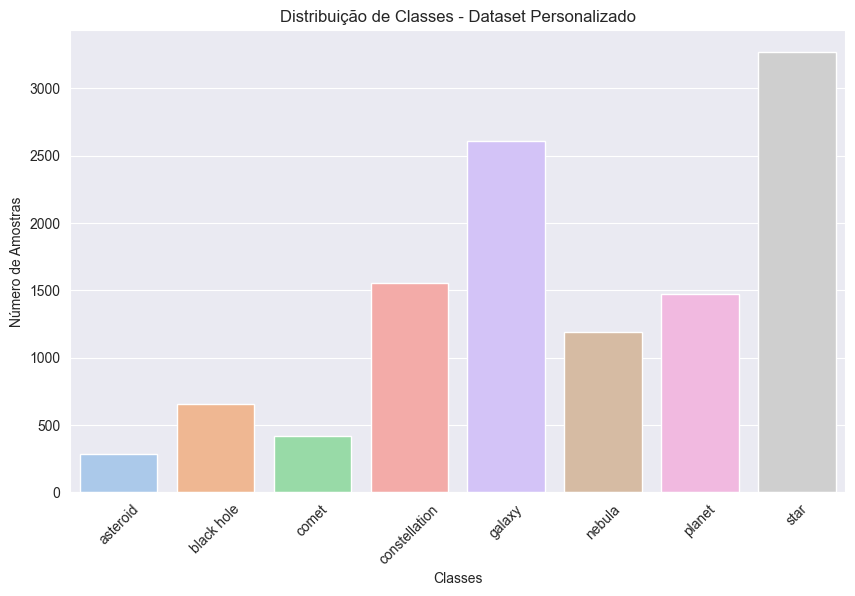

In [30]:
import collections
import matplotlib.pyplot as plt
import seaborn as sns

def plot_class_distribution(subset, dataset, title="Dataset"):
    """
    Visualizar a distribuição das classes em um Subset.
    - subset: objeto Subset (e.g., train_dataset, val_dataset, test_dataset) ou None para o dataset completo
    - dataset: dataset original (e.g., dataset)
    - title: título para o gráfico
    """
    print(f"[INFO] Analisando a distribuição das classes para: {title}")
    
    # Verificar se é um Subset para trabalhar apenas com os índices fornecidos
    if subset is not None:
        indices = subset.indices
        labels = [dataset.targets[i] for i in indices]
    else:
        # Caso seja o dataset completo
        labels = dataset.targets
    
    # Obter os nomes das classes
    class_names = dataset.classes
    
    # Contar a distribuição das classes
    class_counts = collections.Counter([class_names[label] for label in labels])
    total_samples = sum(class_counts.values())

    # Exibir estatísticas
    print(f"\n[INFO] Número total de amostras no {title}: {total_samples}")
    for class_name, count in class_counts.items():
        print(f"Classe '{class_name}': {count} amostras ({(count / total_samples) * 100:.2f}%)")

    # Gráfico de Barras
    class_names_list = list(class_counts.keys())
    class_values = list(class_counts.values())
    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_names_list, y=class_values, palette="pastel")
    plt.title(f"Distribuição de Classes - {title}")
    plt.xlabel("Classes")
    plt.ylabel("Número de Amostras")
    plt.xticks(rotation=45)
    plt.show()

# Dataset personalizado
dataset_custom = load_dataset("data/SpaceNet.FLARE.imam_alam")
plot_class_distribution(None, dataset_custom, title="Dataset Personalizado")


---

## 7. Dividir o Dataset em Treino, Validação e Teste

Esta função utiliza o `random_split` do PyTorch para dividir um dataset em três partes: treinamento, validação e teste, de acordo com proporções especificadas.

---

## **Explicação do Código**

### **1. Função `split_dataset`**
#### **Objetivo**
Dividir o dataset original em três subconjuntos:
- **Treinamento**: Usado para treinar o modelo.
- **Validação**: Usado para ajustar hiperparâmetros e evitar overfitting.
- **Teste**: Usado para avaliar a performance final do modelo.

---

### **2. Parâmetros da Função**
- **`dataset`**: Dataset original a ser dividido.
- **`val_split`**: Proporção do dataset destinada ao conjunto de validação (padrão: 20%).
- **`test_split`**: Proporção do dataset destinada ao conjunto de teste (padrão: 10%).

---

### **3. Cálculo dos Tamanhos dos Conjuntos**
```python
test_size = int(len(dataset) * test_split)
val_size = int(len(dataset) * val_split)
train_size = len(dataset) - test_size - val_size
```
- Calcula o número de amostras para teste e validação.
- O número de amostras de treinamento é o restante após subtrair as amostras de teste e validação.

---

### **4. Divisão com `random_split`**
```python
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
```
- **`random_split`**: Divide o dataset em subconjuntos com os tamanhos especificados.
- A divisão é aleatória e preserva as proporções definidas.

---

### **5. Exibição dos Tamanhos**
```python
print(f"[INFO] Tamanho do conjunto de treino: {len(train_dataset)}")
print(f"[INFO] Tamanho do conjunto de validação: {len(val_dataset)}")
print(f"[INFO] Tamanho do conjunto de teste: {len(test_dataset)}")
```
- Exibe o número de amostras em cada subconjunto após a divisão.

---

### **6. Retorno**
```python
return train_dataset, val_dataset, test_dataset
```
- Retorna os três subconjuntos criados: `train_dataset`, `val_dataset`, `test_dataset`.

---

## **Execução**
1. **Chamada da Função**
   ```python
   train_dataset, val_dataset, test_dataset = split_dataset(dataset)
   ```
   Divide o dataset carregado anteriormente em três subconjuntos.

2. **Proporções Padrão**
   - Treinamento: 70% do dataset original.
   - Validação: 20% do dataset original.
   - Teste: 10% do dataset original.

---

## **Exemplo de Saída**
Para um dataset com 1000 amostras:
```plaintext
[INFO] Dividindo o dataset...
[INFO] Tamanho do conjunto de treino: 700
[INFO] Tamanho do conjunto de validação: 200
[INFO] Tamanho do conjunto de teste: 100
```

---

## **Resumo**

### **Objetivo**
- Dividir um dataset de forma eficiente e com proporções ajustáveis.

### **Utilidade**
- Organizar o dataset em subconjuntos para treinar, validar e testar o modelo, garantindo a separação entre os dados usados durante o treinamento e os dados usados para avaliação.

### **Vantagem**
A divisão aleatória com `random_split` garante que os subconjuntos sejam balanceados e representativos do dataset original.

In [31]:
def split_dataset(dataset, val_split=0.2, test_split=0.1):
    """Dividir o dataset em treino, validação e teste."""
    print("[INFO] Dividindo o dataset...")
    test_size = int(len(dataset) * test_split)
    val_size = int(len(dataset) * val_split)
    train_size = len(dataset) - test_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    print(f"[INFO] Tamanho do conjunto de treino: {len(train_dataset)}")
    print(f"[INFO] Tamanho do conjunto de validação: {len(val_dataset)}")
    print(f"[INFO] Tamanho do conjunto de teste: {len(test_dataset)}")
    return train_dataset, val_dataset, test_dataset

# Dividir o dataset
train_dataset, val_dataset, test_dataset = split_dataset(dataset)

[INFO] Dividindo o dataset...
[INFO] Tamanho do conjunto de treino: 8015
[INFO] Tamanho do conjunto de validação: 2289
[INFO] Tamanho do conjunto de teste: 1144


### 7.1. Visualizar a Distribuição das Classes nos Conjuntos

Verificamos se a distribuição das classes está consistente nos diferentes conjuntos.

---

#### Conjunto de Treino

[INFO] Analisando a distribuição das classes para: Conjunto de Treino

[INFO] Número total de amostras no Conjunto de Treino: 8015
Classe 'asteroid': 203 amostras (2.53%)
Classe 'nebula': 840 amostras (10.48%)
Classe 'star': 2276 amostras (28.40%)
Classe 'constellation': 1100 amostras (13.72%)
Classe 'galaxy': 1790 amostras (22.33%)
Classe 'planet': 1051 amostras (13.11%)
Classe 'black hole': 454 amostras (5.66%)
Classe 'comet': 301 amostras (3.76%)


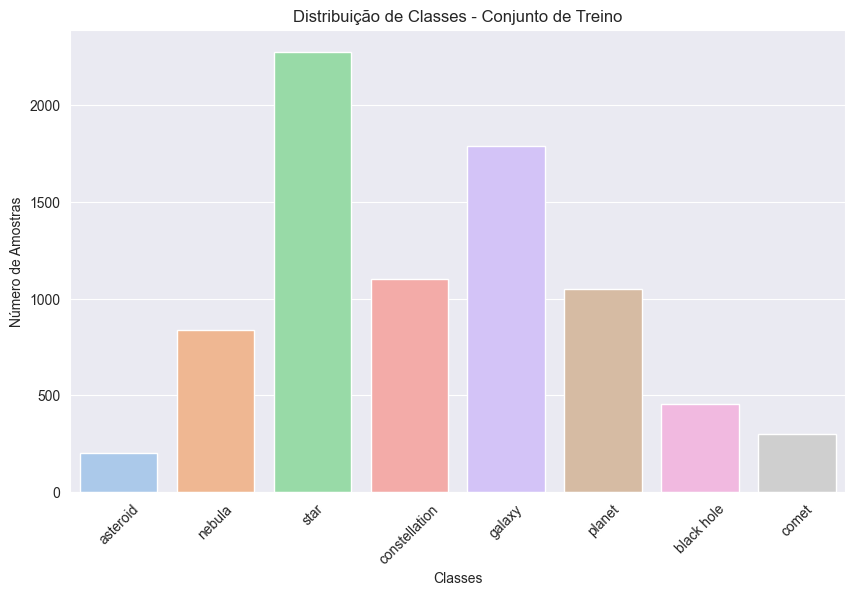

In [32]:
# Visualizar a distribuição no conjunto de treino
plot_class_distribution(train_dataset, dataset, title="Conjunto de Treino")

#### Conjunto de Validação

[INFO] Analisando a distribuição das classes para: Conjunto de Validação

[INFO] Número total de amostras no Conjunto de Validação: 2289
Classe 'constellation': 293 amostras (12.80%)
Classe 'asteroid': 54 amostras (2.36%)
Classe 'nebula': 222 amostras (9.70%)
Classe 'galaxy': 551 amostras (24.07%)
Classe 'star': 672 amostras (29.36%)
Classe 'black hole': 136 amostras (5.94%)
Classe 'comet': 79 amostras (3.45%)
Classe 'planet': 282 amostras (12.32%)


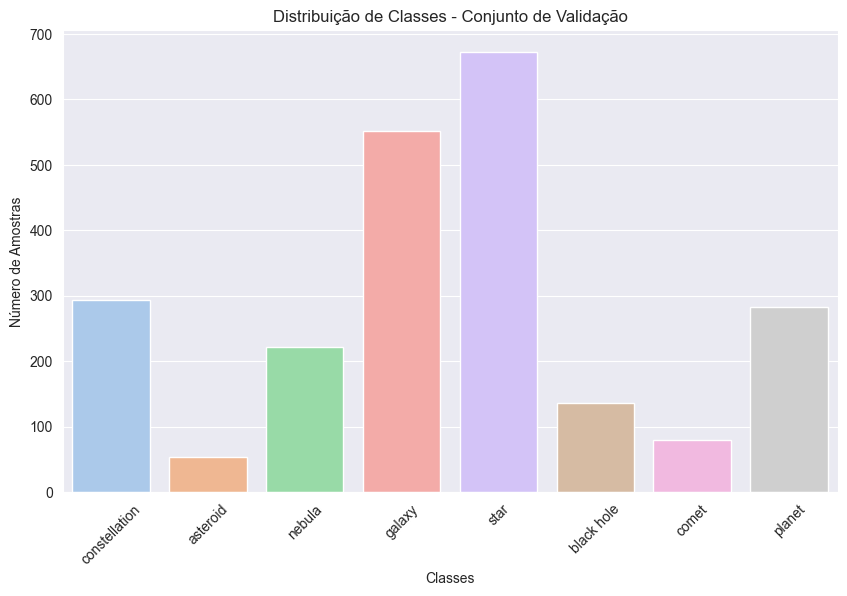

In [33]:
# Visualizar a distribuição no conjunto de validação
plot_class_distribution(val_dataset, dataset, title="Conjunto de Validação")

#### Conjunto de Teste

[INFO] Analisando a distribuição das classes para: Conjunto de Teste

[INFO] Número total de amostras no Conjunto de Teste: 1144
Classe 'planet': 139 amostras (12.15%)
Classe 'galaxy': 267 amostras (23.34%)
Classe 'constellation': 159 amostras (13.90%)
Classe 'star': 321 amostras (28.06%)
Classe 'black hole': 66 amostras (5.77%)
Classe 'asteroid': 26 amostras (2.27%)
Classe 'comet': 36 amostras (3.15%)
Classe 'nebula': 130 amostras (11.36%)


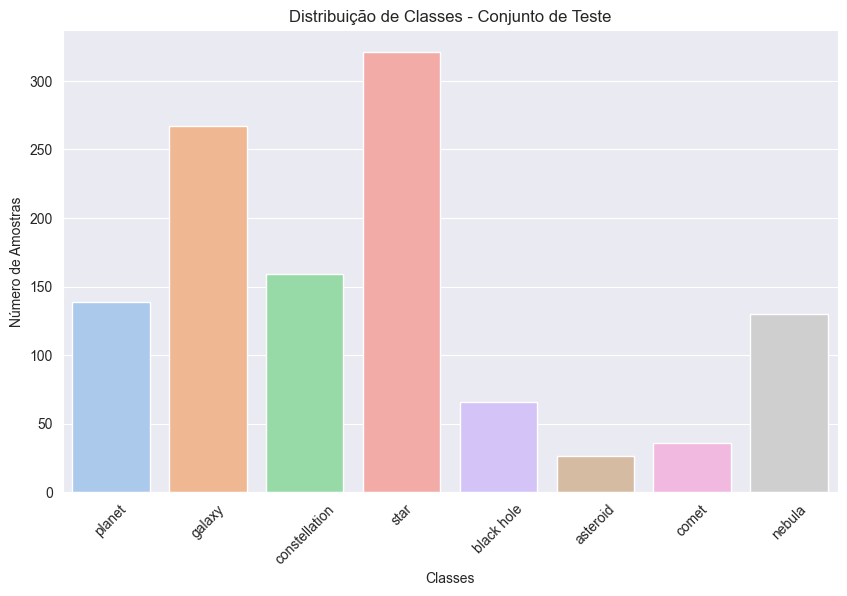

In [34]:
# Visualizar a distribuição no conjunto de teste
plot_class_distribution(test_dataset, dataset, title="Conjunto de Teste")

---

## 8. Criar os DataLoaders

Esta função configura os DataLoaders para carregar os dados de treino, validação e teste, com opções ajustáveis, como tamanho do batch e número de workers. No caso específico de execução em um Jupyter Notebook, o número de workers é fixado em **0** para evitar problemas de compatibilidade.
---

## **Explicação do Código**

### **1. Parâmetros da Função**
- **`train_dataset`**, **`val_dataset`**, **`test_dataset`**:
  - Os datasets divididos para treino, validação e teste.
- **`batch_size`**:
  - Define o número de amostras processadas em paralelo a cada iteração. Padrão: 32.

---

### **2. Configuração dos DataLoaders**
#### **Parâmetros Comuns**
- **`batch_size`**: Número de amostras processadas em cada batch.
- **`shuffle`**:
  - **`True`** no treinamento para embaralhar os dados.
  - **`False`** na validação e no teste para preservar a ordem.
- **`num_workers=0`**:
  - Número de subprocessos usados para carregar os dados. Com **0**, o carregamento é feito no processo principal.
- **`pin_memory=False`**:
  - Desabilita o "pinned memory", útil para aceleração com GPU, mas irrelevante aqui, pois não há múltiplos workers.

---

### **3. Mensagens Informativas**
- Indica a criação dos DataLoaders e que o carregamento está sendo realizado sem paralelização:
  ```plaintext
  [INFO] Criando DataLoaders sem paralelização (num_workers=0).
  [INFO] DataLoaders criados sem paralelização.
  ```

---

## **Por Que `num_workers=0` no Jupyter Notebook?**
No Jupyter Notebook, configurar múltiplos workers no `DataLoader` pode causar problemas de execução devido à maneira como o Python gerencia subprocessos no ambiente interativo. Os principais motivos são:

1. **Incompatibilidade com Multiprocessing**:
   - O Jupyter Notebook cria e gerencia processos de forma diferente em comparação a scripts Python normais. Isso pode gerar conflitos ao tentar inicializar múltiplos subprocessos.

2. **Conflitos de Contexto**:
   - O método padrão de multiprocessing em Jupyter é **`fork`** (em sistemas baseados em Unix), que não funciona bem para ambientes complexos como DataLoaders.

3. **Soluções como `spawn` não são padrão**:
   - Alterar o método de multiprocessing para **`spawn`** pode resolver, mas adiciona complexidade desnecessária para a maioria dos casos.

### **Por Que Não Usar Paralelismo?**
- Para garantir estabilidade e evitar erros, o carregamento de dados no processo principal (**`num_workers=0`**) é mais confiável no ambiente do Jupyter.

---

## **Retorno da Função**
A função retorna três objetos:
- **`train_loader`**: DataLoader para os dados de treino.
- **`val_loader`**: DataLoader para os dados de validação.
- **`test_loader`**: DataLoader para os dados de teste.

---

## **Resumo**
### **Objetivo**
- Configurar DataLoaders para carregar dados de forma eficiente, mesmo em ambientes interativos como Jupyter Notebook.

### **Por Que `num_workers=0`?**
- Evita problemas de compatibilidade com multiprocessing no Jupyter Notebook.
- Simplicidade e estabilidade são priorizadas nesse ambiente.

### **Saída**
- Três DataLoaders prontos para serem usados no treinamento, validação e teste de modelos.

In [35]:
def get_data_loaders(train_dataset, val_dataset, test_dataset, batch_size=32):
    """
    Criar DataLoaders para treino, validação e teste.
    O carregamento será feito exclusivamente na CPU (num_workers=0).
    """
    print("[INFO] Criando DataLoaders sem paralelização (num_workers=0).")

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,  # Carregamento feito no processo principal
        pin_memory=False  # Não usar pin_memory para evitar conflitos com a GPU
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=False
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=False
    )
    print("[INFO] DataLoaders criados sem paralelização.")
    return train_loader, val_loader, test_loader


---

## 9. Definir o Modelo

Esta função utiliza o modelo ResNet18 pré-treinado, personalizando a camada totalmente conectada (fully connected) para adaptá-lo a um número específico de classes. Além disso, inclui unidades ocultas e dropout para regularização.
---
## **Explicação do Código**

### **1. Função `create_model`**
#### **Objetivo**
Criar um modelo baseado na arquitetura **ResNet18**, personalizando a última camada (fully connected) para atender às necessidades específicas de classificação.

#### **Parâmetros**
- **`num_classes`**: Número de classes para o problema de classificação (padrão: 8).
- **`hidden_units`**: Número de unidades na camada oculta antes da saída final (padrão: 512).
- **`dropout_rate`**: Taxa de dropout para regularização (padrão: 0.4).

---

### **2. Carregamento do Modelo Pré-Treinado**
```python
model = models.resnet18(weights='IMAGENET1K_V1')
```
- Utiliza a **ResNet18** pré-treinada no dataset **ImageNet**.
- A transferência de aprendizado ajuda a acelerar o treinamento e melhorar a performance em tarefas de classificação.

---

### **3. Movendo o Modelo para o Dispositivo**
```python
try:
    model = model.to(device)
except RuntimeError as e:
    print("[ERRO] Falha ao mover o modelo para o dispositivo:", e)
    raise e
```
- **`model.to(device)`**: Move o modelo para o dispositivo configurado (`cuda` para GPU ou `cpu` caso a GPU não esteja disponível).
- **Tratamento de Erros**:
  - Captura erros relacionados à alocação de memória no dispositivo, especialmente em sistemas com GPUs limitadas.

---

### **4. Personalização da Camada Fully Connected**
```python
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, hidden_units),
    nn.ReLU(),
    nn.Dropout(dropout_rate),
    nn.Linear(hidden_units, num_classes)
)
```
- **`model.fc`**: Substitui a camada fully connected original da ResNet18.
- **Camadas Adicionais**:
  - **`nn.Linear`**: Camadas lineares que mapeiam para os neurônios ocultos e, posteriormente, para o número de classes.
  - **`nn.ReLU`**: Função de ativação ReLU.
  - **`nn.Dropout`**: Regularização para evitar overfitting.

---

### **5. Criação e Movimentação do Modelo**
```python
try:
    model = create_model()
    model = model.to(device)
    print("[INFO] Modelo movido para o dispositivo:", device)
except RuntimeError as e:
    print("[ERRO] Falha ao mover o modelo para o dispositivo:", e)
    raise e
```
- Chama a função `create_model` e transfere o modelo para o dispositivo especificado.
- Garante que o modelo está pronto para ser treinado ou inferido.

---

## **Por Que Utilizar ResNet18?**
1. **Eficiência Computacional**:
   - Arquitetura leve, ideal para sistemas com recursos limitados.
2. **Capacidade de Generalização**:
   - Pré-treinado no ImageNet, fornecendo pesos otimizados para características genéricas de imagens.
3. **Facilidade de Personalização**:
   - A camada fully connected pode ser substituída facilmente para atender a diferentes problemas.

---

## **Exemplo de Saída**
1. Se o modelo for criado com sucesso e movido para o dispositivo:
   ```plaintext
   [INFO] Criando o modelo ResNet18...
   [INFO] Modelo criado.
   [INFO] Modelo movido para o dispositivo: cuda
   ```

2. Se ocorrer um erro ao mover o modelo para o dispositivo:
   ```plaintext
   [ERRO] Falha ao mover o modelo para o dispositivo: <mensagem de erro>
   ```

---

## **Resumo**

### **Objetivo**
- Criar um modelo baseado na ResNet18 pré-treinada e personalizá-lo para uma tarefa de classificação com 8 classes.

### **Características**
- Personalização da camada fully connected.
- Adição de unidades ocultas e dropout para regularização.

### **Vantagem**
- Utiliza transferência de aprendizado para melhorar a performance e reduzir o tempo de treinamento.

### **Saída**
- Um modelo ResNet18 adaptado e transferido para o dispositivo configurado (`cuda` ou `cpu`).

In [36]:
def create_model(num_classes=8, hidden_units=512, dropout_rate=0.4):
    """Criar o modelo ResNet18 personalizado."""
    print("[INFO] Criando o modelo ResNet18...")

    # Carregar o modelo ResNet18 pré-treinado
    model = models.resnet18(weights='IMAGENET1K_V1')

    try:
        # Verificar se a transferência para a GPU é possível
        model = model.to(device)
    except RuntimeError as e:
        print("[ERRO] Falha ao mover o modelo para o dispositivo:", e)
        raise e

    # Personalizar a camada fully connected (fc)
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, hidden_units),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(hidden_units, num_classes)
    )

    print("[INFO] Modelo criado.")
    return model

try:
    model = create_model()
    model = model.to(device)
    print("[INFO] Modelo movido para o dispositivo:", device)
except RuntimeError as e:
    print("[ERRO] Falha ao mover o modelo para o dispositivo:", e)
    raise e


[INFO] Criando o modelo ResNet18...
[INFO] Modelo criado.
[INFO] Modelo movido para o dispositivo: cuda


---

## 10. Definir Funções de Treinamento e Validação

### 10.1. Função de Validação

A função `validate_model` avalia o desempenho de um modelo treinado em um conjunto de validação, utilizando a biblioteca **TQDM** para exibir uma barra de progresso e calculando métricas de avaliação como **Acurácia**, **F1-Score**, **Precisão** e **Recall**.

---

## **Explicação do Código**

### **1. Preparação**
- O modelo é colocado em modo de avaliação:
  ```python
  model.eval()
  ```
  Desativa camadas como dropout e batch normalization, essenciais para uma avaliação estável.
- Variáveis para acumular a perda e as previsões:
  ```python
  val_loss = 0.0
  y_true, y_pred = [], []
  ```

---

### **2. Barra de Progresso com TQDM**
```python
with tqdm(total=len(val_loader), desc="Validando", unit='batch') as pbar:
```
- **`total=len(val_loader)`**: Define o número total de batches na barra de progresso.
- **`desc="Validando"`**: Descrição exibida na barra.
- **`unit='batch'`**: Unidade da barra, mostrando o progresso em termos de batches.

---

### **3. Iteração sobre o Conjunto de Validação**
#### **Transferência de Dados para o Dispositivo**
```python
images, labels = images.to(device), labels.to(device)
```
- Garante que os tensores de entrada e saída sejam processados na GPU (ou CPU).

#### **Verificação de Rótulos**
```python
if torch.max(labels) >= model.fc[-1].out_features or torch.min(labels) < 0:
    print(f"[ERRO] Labels fora do intervalo: {torch.unique(labels)}")
    raise ValueError(f"Labels fora do intervalo! Esperado [0, {model.fc[-1].out_features - 1}]")
```
- Verifica se os rótulos estão dentro do intervalo esperado.
- Previne erros em casos de dados rotulados incorretamente.

#### **Cálculo da Perda**
```python
outputs = model(images)
loss = criterion(outputs, labels)
val_loss += loss.item()
```
- **`model(images)`**: Realiza a inferência no modelo.
- **`criterion(outputs, labels)`**: Calcula a perda do batch atual.

#### **Previsões**
```python
_, preds = torch.max(outputs, 1)
y_true.extend(labels.cpu().numpy())
y_pred.extend(preds.cpu().numpy())
```
- Obtém a classe prevista para cada amostra no batch.
- Move os tensores para a CPU para acumulação nas listas `y_true` e `y_pred`.

---

### **4. Atualização da Barra de Progresso**
```python
pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
pbar.update(1)
```
- Exibe a perda do batch atual na barra de progresso.
- Atualiza a barra após processar cada batch.

---

### **5. Cálculo de Métricas**
```python
val_loss /= len(val_loader)
val_accuracy = accuracy_score(y_true, y_pred)
val_f1 = f1_score(y_true, y_pred, average='weighted')
val_precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
val_recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
```
- **`val_loss`**: Perda média no conjunto de validação.
- **Métricas de Avaliação**:
  - **Acurácia** (`accuracy_score`): Proporção de previsões corretas.
  - **F1-Score** (`f1_score`): Média ponderada de precisão e recall.
  - **Precisão** (`precision_score`): Proporção de previsões corretas dentre todas as previsões.
  - **Recall** (`recall_score`): Proporção de amostras corretamente previstas em relação ao total real.

---

### **6. Exibição dos Resultados**
```python
print(f"[VALIDAÇÃO] Loss: {val_loss:.4f}, Acurácia: {val_accuracy:.4f}, F1-Score: {val_f1:.4f}, Precisão: {val_precision:.4f}, Recall: {val_recall:.4f}")
```
- Mostra as métricas calculadas para o conjunto de validação.

---

### **7. Retorno**
```python
return val_loss, val_accuracy, val_f1
```
- Retorna as métricas mais importantes (perda, acurácia e F1-Score) para análises posteriores.

---

## **Exemplo de Saída**
1. Barra de progresso durante a validação:
   ```plaintext
   Validando: 100%|██████████| 50/50 [00:10<00:00, 4.88batch/s, Loss=0.1234]
   ```
2. Resumo final:
   ```plaintext
   [VALIDAÇÃO] Loss: 0.2345, Acurácia: 0.8900, F1-Score: 0.8723, Precisão: 0.8801, Recall: 0.8900
   ```

---

## **Resumo**
### **Objetivo**
- Avaliar o modelo no conjunto de validação.
- Exibir métricas detalhadas de performance.

### **Vantagens**
- **TQDM**: Facilita o acompanhamento do progresso em tempo real.
- **Métricas Padrão**: Inclui acurácia, F1-Score, precisão e recall.

### **Recomendações**
Certifique-se de que os rótulos no conjunto de validação estão no intervalo esperado para evitar erros.

In [37]:
def validate_model(model, val_loader, criterion):
    """Função para validar o modelo, usando TQDM para barras de progresso."""
    model.eval()
    val_loss = 0.0
    y_true, y_pred = [], []

    # Usar TQDM para a barra de progresso
    with tqdm(total=len(val_loader), desc="Validando", unit='batch') as pbar:
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                # Verificação: Certifique-se de que os rótulos estão dentro do intervalo esperado
                if torch.max(labels) >= model.fc[-1].out_features or torch.min(labels) < 0:
                    print(f"[ERRO] Labels fora do intervalo: {torch.unique(labels)}")
                    raise ValueError(f"Labels fora do intervalo! Esperado [0, {model.fc[-1].out_features - 1}]")

                # Realizar a inferência e calcular a perda
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Obter as previsões
                _, preds = torch.max(outputs, 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

                # Atualizar a descrição da barra de progresso
                pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
                pbar.update(1)

    val_loss /= len(val_loader)
    val_accuracy = accuracy_score(y_true, y_pred)
    val_f1 = f1_score(y_true, y_pred, average='weighted')
    val_precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    val_recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f"[VALIDAÇÃO] Loss: {val_loss:.4f}, Acurácia: {val_accuracy:.4f}, F1-Score: {val_f1:.4f}, Precisão: {val_precision:.4f}, Recall: {val_recall:.4f}")

    return val_loss, val_accuracy, val_f1


### 10.2. Função de Treinamento

A função `train_model` realiza o treinamento do modelo utilizando TQDM para exibir barras de progresso durante cada época e batch, além de implementar o **Early Stopping** para interromper o treinamento caso o modelo pare de melhorar no conjunto de validação.
---
## **Explicação do Código**

### **1. Preparação do Treinamento**
- **Histórico de Métricas**:
  ```python
  history = {
      'train_loss': [],
      'train_accuracy': [],
      'train_f1': [],
      'val_loss': [],
      'val_accuracy': [],
      'val_f1': []
  }
  ```
  - Armazena métricas de perda, acurácia e F1-Score para análise posterior.
- **Early Stopping**:
  - Variáveis para rastrear o menor valor de validação, a melhor época e o contador de paciência.

---

### **2. Laço de Épocas**
- Para cada época:
  - O modelo é colocado em modo de treinamento:
    ```python
    model.train()
    ```
  - As variáveis de rastreamento são inicializadas para cada época.

---

### **3. Treinamento com TQDM**
- Barra de progresso para batches:
  ```python
  with tqdm(total=len(train_loader), desc=f"Treinando (Época {epoch + 1}/{num_epochs})", unit='batch') as pbar:
  ```
  - Exibe o progresso e atualiza a perda por batch.

---

### **4. Validação**
- Utiliza a função `validate_model` para avaliar o modelo no conjunto de validação.
- Armazena métricas de validação.

---

### **5. Early Stopping**
- Compara a perda de validação com o menor valor registrado:
  ```python
  if val_loss < best_val_loss:
      best_val_loss = val_loss
      best_epoch = epoch + 1
      patience_counter = 0
      torch.save(model.state_dict(), 'best_model.pth')
  ```
- Incrementa o contador de paciência se não houver melhora:
  ```python
  else:
      patience_counter += 1
      if patience_counter >= patience:
          print("[INFO] Early stopping ativado.")
          break
  ```

---

### **6. Resumo Final**
- Exibe o número de épocas realizadas, as melhores métricas e a época com melhor desempenho.

---

## **Exemplo de Saída**
```plaintext
[INFO] Iniciando o treinamento do modelo...

[ÉPOCA 1/5]
Treinando (Época 1/5): 100%|██████████| 50/50 [00:12<00:00, 4.12batch/s, Loss=0.3456]
[TREINO] Loss: 0.5678, Acurácia: 0.8123, F1-Score: 0.7987
[VALIDAÇÃO] Loss: 0.4567, Acurácia: 0.8345, F1-Score: 0.8201

[INFO] Melhor loss de validação encontrado. Salvando o modelo...
```

---

## **Resumo**
### **Objetivo**
- Treinar um modelo com monitoramento detalhado de progresso e validação, aplicando Early Stopping para eficiência.

### **Características**
- Métricas detalhadas de desempenho.
- Barra de progresso para cada batch.
- Salvamento automático do melhor modelo.

### **Saída**
- Histórico de métricas (`history`) para análises posteriores.
- Modelo salvo com os melhores pesos durante o treinamento.

In [38]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, patience=2):
    """Função para treinar o modelo com Early Stopping, usando TQDM para barras de progresso."""
    print("\n[INFO] Iniciando o treinamento do modelo...")
    
    # Variáveis para rastrear o melhor modelo
    best_val_loss = float('inf')
    best_epoch = -1
    patience_counter = 0

    # Armazenar métricas para cada época
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'train_f1': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_f1': []
    }

    for epoch in range(num_epochs):
        print(f"\n[ÉPOCA {epoch + 1}/{num_epochs}]")
        model.train()
        train_loss = 0.0
        y_true_train, y_pred_train = [], []

        # Usar TQDM para a barra de progresso dos batches
        with tqdm(total=len(train_loader), desc=f"Treinando (Época {epoch + 1}/{num_epochs})", unit='batch') as pbar:
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                y_true_train.extend(labels.cpu().numpy())
                y_pred_train.extend(preds.cpu().numpy())

                # Atualizar a descrição da barra de progresso
                pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
                pbar.update(1)

        # Calcular métricas de treino
        train_loss /= len(train_loader)
        train_accuracy = accuracy_score(y_true_train, y_pred_train)
        train_f1 = f1_score(y_true_train, y_pred_train, average='weighted')

        print(f"[TREINO] Loss: {train_loss:.4f}, Acurácia: {train_accuracy:.4f}, F1-Score: {train_f1:.4f}")

        # Armazenar métricas de treino
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_accuracy)
        history['train_f1'].append(train_f1)

        # Validação
        val_loss, val_accuracy, val_f1 = validate_model(model, val_loader, criterion)

        # Armazenar métricas de validação
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)
        history['val_f1'].append(val_f1)

        print(f"[VALIDAÇÃO] Loss: {val_loss:.4f}, Acurácia: {val_accuracy:.4f}, F1-Score: {val_f1:.4f}")

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch + 1
            patience_counter = 0
            print("[INFO] Melhor loss de validação encontrado. Salvando o modelo...")
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            print(f"[INFO] Patience counter: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print("[INFO] Early stopping ativado.")
                break

    # Resumo Final
    print("\n" + "=" * 50)
    print("[RESUMO DO TREINAMENTO]")
    print("=" * 50)
    print(f"Total de épocas realizadas: {epoch + 1}")
    print(f"Melhor época: {best_epoch}")
    print(f"Melhor Loss de Validação: {best_val_loss:.4f}")
    print(f"Acurácia de Treinamento na última época: {history['train_accuracy'][-1]:.4f}")
    print(f"Acurácia de Validação na última época: {history['val_accuracy'][-1]:.4f}")
    print(f"F1-Score de Treinamento na última época: {history['train_f1'][-1]:.4f}")
    print(f"F1-Score de Validação na última época: {history['val_f1'][-1]:.4f}")
    print("=" * 50)
    print("[INFO] Treinamento concluído.")

    # Retornar o histórico para análise posterior, se necessário
    return history

---

## 11. Treinar o Modelo

Iniciamos o processo de treinamento do modelo usando as funções definidas.

---

### Carregar o Dataset
Esta etapa utiliza a função `load_dataset` para carregar o dataset a partir do diretório especificado, aplicando as transformações e verificações necessárias.

---

## **Explicação**

### **1. Caminho do Dataset**
```python
dataset_path = "data/SpaceNet.FLARE.imam_alam"
```
- Define o caminho para o diretório onde o dataset está armazenado. Certifique-se de que o diretório contém os arquivos de imagem organizados em subpastas, representando as classes.

---

### **2. Função `load_dataset`**
```python
dataset = load_dataset(dataset_path)
```
- A função `load_dataset` realiza:
  - **Carregamento das imagens**: Utiliza um loader personalizado (`pil_loader`) para garantir que os arquivos são imagens válidas.
  - **Transformações**: Aplica redimensionamento, normalização e conversão para tensores.
  - **Validação**: Verifica se os arquivos têm extensões válidas e estão organizados corretamente.

---

## **Saída**
Se o dataset for carregado com sucesso, a função retorna um objeto do tipo `DatasetFolder` com:
- **Amostras carregadas**: Contendo as imagens e seus respectivos rótulos.
- **Transformações aplicadas**: Garantindo que os dados estão no formato esperado para o treinamento do modelo.

### **Exemplo de Log**
```plaintext
[INFO] Carregando o dataset...
[INFO] Total de amostras carregadas: 1200
```

---

## **Resumo**
### **Objetivo**
- Carregar e pré-processar as imagens de um dataset para uso em modelos de deep learning.

### **Requisitos**
- Um diretório contendo subpastas organizadas por classes.
- Implementação da função `load_dataset`.

### **Próximos Passos**
- Dividir o dataset em conjuntos de treino, validação e teste usando a função `split_dataset`.
- Criar DataLoaders para carregamento eficiente dos dados.


In [39]:
# Carregar o dataset
dataset_path = "data/SpaceNet.FLARE.imam_alam"
dataset = load_dataset(dataset_path)

[INFO] Carregando o dataset...
[INFO] Total de amostras carregadas: 11448


### Dividir o Dataset em Conjuntos de Treino, Validação e Teste

Nesta etapa, o dataset carregado é dividido em três subconjuntos: **treinamento**, **validação** e **teste**. Essa divisão é crucial para garantir que o modelo seja avaliado adequadamente em dados que não foram utilizados durante o treinamento.

---

## **Explicação**

### **1. Função `split_dataset`**
- Divide o dataset original (`dataset`) em três partes:
  - **Treinamento (`train_dataset`)**:
    - Usado para ajustar os parâmetros do modelo.
  - **Validação (`val_dataset`)**:
    - Usado para ajustar hiperparâmetros e monitorar overfitting.
  - **Teste (`test_dataset`)**:
    - Usado para avaliar o desempenho final do modelo em dados completamente desconhecidos.

### **2. Proporções Padrão**
A função utiliza valores padrão de divisão:
- **Treinamento**: 70% do dataset.
- **Validação**: 20% do dataset.
- **Teste**: 10% do dataset.

---

## **Saída**
A função retorna três subconjuntos:
- **`train_dataset`**: Conjunto de treinamento.
- **`val_dataset`**: Conjunto de validação.
- **`test_dataset`**: Conjunto de teste.

### **Exemplo de Log**
Supondo que o dataset tenha 1000 amostras:
```plaintext
[INFO] Dividindo o dataset...
[INFO] Tamanho do conjunto de treino: 700
[INFO] Tamanho do conjunto de validação: 200
[INFO] Tamanho do conjunto de teste: 100
```

---

## **Resumo**
### **Objetivo**
- Dividir o dataset em três subconjuntos para garantir uma avaliação justa do modelo.

### **Importância**
- **Treinamento**: Ajusta os pesos do modelo.
- **Validação**: Detecta overfitting e ajusta hiperparâmetros.
- **Teste**: Fornece uma estimativa precisa do desempenho em produção.

### **Próximos Passos**
- Criar os **DataLoaders** para carregar os dados de forma eficiente durante o treinamento e avaliação do modelo.


In [40]:
# Dividir o dataset em treino, validação e teste
train_dataset, val_dataset, test_dataset = split_dataset(dataset)

[INFO] Dividindo o dataset...
[INFO] Tamanho do conjunto de treino: 8015
[INFO] Tamanho do conjunto de validação: 2289
[INFO] Tamanho do conjunto de teste: 1144


### Configura os **DataLoaders** para carregar os dados em mini-lotes durante o treinamento.

Nesta etapa, os **DataLoaders** são configurados para carregar os dados dos conjuntos de treino, validação e teste em batches, garantindo eficiência durante o treinamento e a avaliação do modelo.

---

## **Explicação**

### **1. Função `get_data_loaders`**
A função `get_data_loaders` cria os DataLoaders a partir dos conjuntos de dados divididos previamente.

#### **Parâmetros**
- **`train_dataset`**, **`val_dataset`**, **`test_dataset`**:
  - Subconjuntos de dados para treino, validação e teste.
- **`batch_size=32`**:
  - Define o número de amostras processadas em cada batch. Padrão: 32.

#### **Configurações dos DataLoaders**
- **`shuffle=True`** no treinamento:
  - Embaralha os dados para melhorar a generalização.
- **`shuffle=False`** na validação e teste:
  - Garante previsibilidade e consistência nas avaliações.
- **`num_workers=0`**:
  - Realiza o carregamento no processo principal (essencial para execução em notebooks, como Jupyter).

---

## **Saída**
A função retorna três DataLoaders:
- **`train_loader`**: Para carregar os dados de treinamento.
- **`val_loader`**: Para carregar os dados de validação.
- **`test_loader`**: Para carregar os dados de teste.

### **Exemplo de Log**
```plaintext
[INFO] Criando DataLoaders sem paralelização (num_workers=0).
[INFO] DataLoaders criados sem paralelização.
[INFO] DataLoaders criados.
```

---

## **Resumo**
### **Objetivo**
- Configurar os DataLoaders para carregar os dados de forma eficiente durante o treinamento, validação e teste.

### **Importância**
- Os DataLoaders gerenciam o carregamento dos dados em batches, otimizando o uso de memória e permitindo que os dados sejam processados em tempo real.

### **Próximos Passos**
- Iniciar o treinamento do modelo utilizando os DataLoaders configurados.


In [41]:
# Criar os DataLoaders
train_loader, val_loader, test_loader = get_data_loaders(
    train_dataset, val_dataset, test_dataset, batch_size=32
)
print("[INFO] DataLoaders criados.")

[INFO] Criando DataLoaders sem paralelização (num_workers=0).
[INFO] DataLoaders criados sem paralelização.
[INFO] DataLoaders criados.


### Cria um modelo baseado na **ResNet18** pré-treinada e adapta sua última camada para o número de classes do dataset.

Nesta etapa, o modelo baseado na arquitetura **ResNet18** é criado e configurado para classificação, sendo personalizado para o número de classes desejado. Após a criação, o modelo é transferido para o dispositivo apropriado (**CPU** ou **GPU**, dependendo da configuração).

---

## **Explicação**

### **1. Função `create_model`**
A função `create_model` configura o modelo com base na arquitetura **ResNet18 pré-treinada**, ajustando a última camada (**fully connected**) para o número de classes do problema.

#### **Características Principais**
- **Arquitetura Base**: ResNet18 pré-treinada no ImageNet.
- **Personalização**:
  - Substitui a camada fully connected original com:
    - **Camadas adicionais**: Linear, ReLU, Dropout.
    - **Saída ajustada**: Igual ao número de classes.
- **Transferência de Aprendizado**:
  - Reaproveita os pesos da ResNet18 para acelerar o treinamento.

---

### **2. Transferência do Modelo para o Dispositivo**
```python
model = model.to(device)
```
- **`device`**:
  - Se CUDA estiver disponível, o modelo é transferido para a GPU (**`cuda`**).
  - Caso contrário, permanece na CPU (**`cpu`**).
- Essa transferência garante que as operações do modelo sejam realizadas no dispositivo mais adequado.

---

## **Saída**
- **`model`**: Um modelo ResNet18 ajustado e alocado no dispositivo correto.

### **Exemplo de Log**
1. Caso o modelo seja criado e transferido com sucesso:
   ```plaintext
   [INFO] Criando o modelo ResNet18...
   [INFO] Modelo criado.
   [INFO] Modelo movido para o dispositivo: cuda
   ```

2. Caso ocorra um erro na transferência:
   ```plaintext
   [ERRO] Falha ao mover o modelo para o dispositivo: <mensagem do erro>
   ```

---

## **Resumo**
### **Objetivo**
- Criar um modelo baseado na ResNet18, ajustá-lo para o problema de classificação e transferi-lo para o dispositivo mais eficiente.

### **Importância**
- Reaproveita uma arquitetura robusta e pré-treinada.
- Configura o modelo para treinar e inferir com eficiência, utilizando GPU quando disponível.

### **Próximos Passos**
- Iniciar o treinamento do modelo utilizando os DataLoaders e os critérios definidos.


In [42]:
# Criar o modelo
model = create_model()
model = model.to(device)

[INFO] Criando o modelo ResNet18...
[INFO] Modelo criado.


### Configura a função de perda (**CrossEntropyLoss**) e o otimizador (**Adam**) para treinar o modelo.

Nesta etapa, a função de perda (**criterion**) e o otimizador (**optimizer**) são configurados. Estes componentes são fundamentais para o treinamento do modelo, pois determinam como o modelo será avaliado e atualizado ao longo do treinamento.

---

## **Explicação**

### **1. Função de Perda (`criterion`)**
```python
criterion = nn.CrossEntropyLoss()
```
- **`nn.CrossEntropyLoss`**:
  - É uma função de perda comumente usada para tarefas de classificação.
  - Combina as operações de softmax na saída do modelo e cálculo da entropia cruzada.
  - Avalia quão bem as previsões do modelo correspondem às classes reais.
- **Uso**:
  - Adequada para problemas de classificação multi-classe com rótulos inteiros representando as classes.

---

### **2. Otimizador (`optimizer`)**
```python
optimizer = optim.Adam(model.parameters(), lr=0.001)
```
- **`optim.Adam`**:
  - Um otimizador adaptativo que combina as vantagens do SGD e do RMSProp.
  - Ajusta dinamicamente a taxa de aprendizado para cada parâmetro do modelo.
- **Parâmetros**:
  - **`model.parameters()`**:
    - Conjunto de parâmetros do modelo que serão atualizados durante o treinamento.
  - **`lr=0.001`**:
    - Taxa de aprendizado inicial.
    - Controla o tamanho dos passos que o otimizador dá na direção do gradiente.

---

## **Saída**
- **`criterion`**: Função de perda que calcula a diferença entre as previsões do modelo e os rótulos reais.
- **`optimizer`**: Otimizador que ajusta os pesos do modelo com base no gradiente calculado pela função de perda.

---

## **Resumo**
### **Objetivo**
- Configurar a métrica de erro (função de perda) e o método de atualização dos pesos (otimizador) para o treinamento do modelo.

### **Componentes**
1. **`criterion`**:
   - Mede o desempenho do modelo durante o treinamento.
2. **`optimizer`**:
   - Ajusta os pesos para reduzir a função de perda.

### **Próximos Passos**
- Iniciar o treinamento do modelo utilizando os DataLoaders, a função de perda e o otimizador configurados.


In [43]:
# Definir a função de perda e o otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Treina o modelo usando os **DataLoaders** configurados, com validação em cada época e **early stopping** para evitar overfitting.

Nesta etapa, o modelo é treinado utilizando os conjuntos de dados, a função de perda, o otimizador e os DataLoaders configurados anteriormente. O treinamento inclui **Early Stopping** para interromper o processo se não houver melhorias no conjunto de validação após um número definido de épocas.

---

## **Explicação**

### **1. Função `train_model`**
#### **Objetivo**
Treinar o modelo enquanto monitora o desempenho no conjunto de validação. A função também salva o modelo com o melhor desempenho durante o treinamento.

---

### **2. Parâmetros**
- **`model`**:
  - O modelo a ser treinado (ResNet18 customizada neste caso).
- **`train_loader`**:
  - DataLoader para carregar os dados de treino em batches.
- **`val_loader`**:
  - DataLoader para carregar os dados de validação.
- **`criterion`**:
  - Função de perda utilizada para calcular o erro entre as previsões do modelo e os rótulos reais.
- **`optimizer`**:
  - Otimizador que ajusta os pesos do modelo para reduzir a função de perda.
- **`num_epochs=5`**:
  - Número máximo de épocas de treinamento.
- **`patience=2`**:
  - Número de épocas consecutivas sem melhoria no conjunto de validação antes de acionar o **Early Stopping**.

---

### **3. Funcionamento do Treinamento**
1. **Treino por Época**:
   - O modelo processa batches do conjunto de treino.
   - Calcula a perda e ajusta os pesos usando backpropagation.
   - Métricas como perda, acurácia e F1-Score são registradas.

2. **Validação**:
   - Após cada época, o modelo é avaliado no conjunto de validação.
   - Métricas de validação são calculadas para monitorar o desempenho.

3. **Early Stopping**:
   - Interrompe o treinamento se o desempenho no conjunto de validação não melhorar após `patience` épocas.
   - Salva o modelo com o menor **loss de validação** como o "melhor modelo".

---

### **4. Retorno**
```python
history
```
- Um dicionário contendo o histórico de métricas para cada época:
  - **`train_loss`**, **`train_accuracy`**, **`train_f1`**: Métricas de treinamento.
  - **`val_loss`**, **`val_accuracy`**, **`val_f1`**: Métricas de validação.

---

## **Saída**
### **Log de Treinamento**
1. Barra de progresso para batches durante o treinamento e validação:
   ```plaintext
   Treinando (Época 1/5): 100%|██████████| 50/50 [00:12<00:00, 4.12batch/s, Loss=0.3456]
   [TREINO] Loss: 0.5678, Acurácia: 0.8123, F1-Score: 0.7987
   Validando: 100%|██████████| 10/10 [00:02<00:00, 4.82batch/s, Loss=0.4567]
   [VALIDAÇÃO] Loss: 0.4567, Acurácia: 0.8345, F1-Score: 0.8201
   ```

2. Mensagens de Early Stopping:
   ```plaintext
   [INFO] Melhor loss de validação encontrado. Salvando o modelo...
   [INFO] Patience counter: 1/2
   [INFO] Early stopping ativado.
   ```

---

## **Resumo**
### **Objetivo**
Treinar o modelo enquanto monitora o desempenho no conjunto de validação, salvando o melhor modelo e interrompendo o treinamento caso o desempenho não melhore.

### **Benefícios**
- **Early Stopping**: Evita overfitting e economiza tempo.
- **Monitoramento**: Histórico detalhado de métricas para análises posteriores.

### **Próximos Passos**
- Avaliar o modelo salvo no conjunto de teste para obter uma estimativa final de desempenho.

In [44]:
# Treinar o modelo
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=5,
    patience=2
)


[INFO] Iniciando o treinamento do modelo...

[ÉPOCA 1/5]


Treinando (Época 1/5): 100%|██████████| 251/251 [10:12<00:00,  2.44s/batch, Loss=1.4783]


[TREINO] Loss: 1.1575, Acurácia: 0.5847, F1-Score: 0.5762


Validando: 100%|██████████| 72/72 [02:47<00:00,  2.33s/batch, Loss=1.9070]


[VALIDAÇÃO] Loss: 1.3737, Acurácia: 0.5828, F1-Score: 0.5444, Precisão: 0.6231, Recall: 0.5828
[VALIDAÇÃO] Loss: 1.3737, Acurácia: 0.5828, F1-Score: 0.5444
[INFO] Melhor loss de validação encontrado. Salvando o modelo...

[ÉPOCA 2/5]


Treinando (Época 2/5): 100%|██████████| 251/251 [10:21<00:00,  2.47s/batch, Loss=0.5764]


[TREINO] Loss: 0.9173, Acurácia: 0.6666, F1-Score: 0.6622


Validando: 100%|██████████| 72/72 [02:49<00:00,  2.36s/batch, Loss=0.4307]


[VALIDAÇÃO] Loss: 0.8666, Acurácia: 0.6741, F1-Score: 0.6623, Precisão: 0.7111, Recall: 0.6741
[VALIDAÇÃO] Loss: 0.8666, Acurácia: 0.6741, F1-Score: 0.6623
[INFO] Melhor loss de validação encontrado. Salvando o modelo...

[ÉPOCA 3/5]


Treinando (Época 3/5): 100%|██████████| 251/251 [10:18<00:00,  2.47s/batch, Loss=0.8304]


[TREINO] Loss: 0.8173, Acurácia: 0.6982, F1-Score: 0.6949


Validando: 100%|██████████| 72/72 [02:49<00:00,  2.35s/batch, Loss=1.0762]


[VALIDAÇÃO] Loss: 1.0021, Acurácia: 0.6754, F1-Score: 0.6637, Precisão: 0.7244, Recall: 0.6754
[VALIDAÇÃO] Loss: 1.0021, Acurácia: 0.6754, F1-Score: 0.6637
[INFO] Patience counter: 1/2

[ÉPOCA 4/5]


Treinando (Época 4/5): 100%|██████████| 251/251 [10:16<00:00,  2.45s/batch, Loss=0.7481]


[TREINO] Loss: 0.7552, Acurácia: 0.7197, F1-Score: 0.7163


Validando: 100%|██████████| 72/72 [02:49<00:00,  2.35s/batch, Loss=0.4094]


[VALIDAÇÃO] Loss: 0.7738, Acurácia: 0.7147, F1-Score: 0.7055, Precisão: 0.7503, Recall: 0.7147
[VALIDAÇÃO] Loss: 0.7738, Acurácia: 0.7147, F1-Score: 0.7055
[INFO] Melhor loss de validação encontrado. Salvando o modelo...

[ÉPOCA 5/5]


Treinando (Época 5/5): 100%|██████████| 251/251 [10:21<00:00,  2.47s/batch, Loss=1.5468]


[TREINO] Loss: 0.6894, Acurácia: 0.7523, F1-Score: 0.7494


Validando: 100%|██████████| 72/72 [02:49<00:00,  2.36s/batch, Loss=0.8413]

[VALIDAÇÃO] Loss: 0.8922, Acurácia: 0.6584, F1-Score: 0.6594, Precisão: 0.6677, Recall: 0.6584
[VALIDAÇÃO] Loss: 0.8922, Acurácia: 0.6584, F1-Score: 0.6594
[INFO] Patience counter: 1/2

[RESUMO DO TREINAMENTO]
Total de épocas realizadas: 5
Melhor época: 4
Melhor Loss de Validação: 0.7738
Acurácia de Treinamento na última época: 0.7523
Acurácia de Validação na última época: 0.6584
F1-Score de Treinamento na última época: 0.7494
F1-Score de Validação na última época: 0.6594
[INFO] Treinamento concluído.


### Métricas Treinamento

Nesta etapa, é criado um gráfico para visualizar como a **perda (loss)** evoluiu ao longo das épocas, tanto para o conjunto de treinamento quanto para o conjunto de validação. Essa visualização ajuda a entender o desempenho do modelo durante o treinamento e a identificar possíveis sinais de overfitting.

---

## **Explicação do Código**

### **1. Configuração do Gráfico**
```python
plt.figure(figsize=(10, 5))
```
- Define o tamanho da figura para uma visualização clara e legível (10 de largura por 5 de altura).

---

### **2. Plotagem das Curvas**
```python
plt.plot(history['train_loss'], label='Loss de Treinamento')
plt.plot(history['val_loss'], label='Loss de Validação')
```
- **`history['train_loss']`**: Valores da perda (loss) para o conjunto de treinamento, armazenados durante o treinamento.
- **`history['val_loss']`**: Valores da perda (loss) para o conjunto de validação.
- **`label`**: Adiciona legendas às curvas para facilitar a identificação.

---

### **3. Títulos e Rótulos**
```python
plt.title("Evolução da Loss durante o Treinamento")
plt.xlabel("Épocas")
plt.ylabel("Loss")
```
- **Título**: Indica o conteúdo do gráfico.
- **Eixo X**: Representa as épocas do treinamento.
- **Eixo Y**: Representa os valores da perda.

---

### **4. Legenda e Grade**
```python
plt.legend()
plt.grid(True)
```
- **`plt.legend()`**: Adiciona uma legenda para diferenciar as curvas.
- **`plt.grid(True)`**: Insere uma grade no gráfico para facilitar a leitura.

---

### **5. Exibição do Gráfico**
```python
plt.show()
```
- Exibe o gráfico gerado.

---

## **Saída Esperada**
O gráfico exibe duas curvas:
- **Loss de Treinamento**:
  - Deve diminuir gradualmente conforme o modelo aprende.
- **Loss de Validação**:
  - Deve seguir um padrão semelhante ao treinamento, mas estabilizar ou aumentar levemente se ocorrer overfitting.

### Exemplo:
```plaintext
Visualização de um gráfico com as curvas da perda (loss) para treino e validação ao longo das épocas.
```

---

## **Resumo**
### **Objetivo**
Visualizar o comportamento da perda (loss) durante o treinamento, ajudando a identificar problemas como overfitting ou underfitting.

### **Benefícios**
- **Overfitting**:
  - Indicado por uma divergência entre as curvas de treinamento e validação.
- **Underfitting**:
  - Indicado por curvas que permanecem altas sem diminuição significativa.

### **Próximos Passos**
- Realizar ajustes nos hiperparâmetros do modelo, como taxa de aprendizado ou número de épocas, com base nos padrões observados no gráfico.

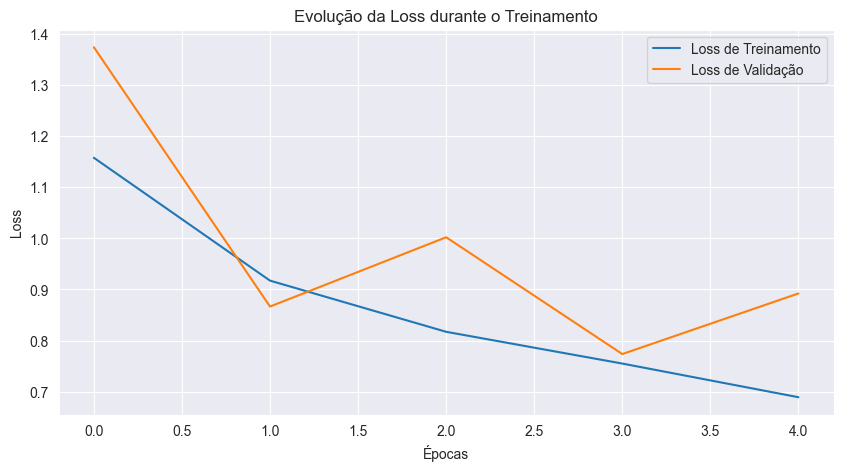

In [45]:
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Loss de Treinamento')
plt.plot(history['val_loss'], label='Loss de Validação')
plt.title("Evolução da Loss durante o Treinamento")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

---

## 12. Avaliar o Modelo no Conjunto de Teste

Nesta etapa, o modelo é avaliado utilizando o conjunto de teste. Diversas métricas de desempenho são calculadas, incluindo:
- Acurácia
- F1-Score
- Precisão
- Recall

Além disso, são gerados gráficos como a **Matriz de Confusão**, a **Curva ROC** e a **Curva de Precisão-Recall** para uma análise mais aprofundada do desempenho por classe.

## **Explicação do Código**

### **1. Avaliação do Modelo**
- **Previsões**:
  ```python
  _, preds = torch.max(outputs, 1)
  probs = torch.softmax(outputs, dim=1)
  ```
  - `preds`: Predições das classes.
  - `probs`: Probabilidades para cada classe após aplicação de softmax.

- **Cálculo de Métricas**:
  - **Acurácia**, **F1-Score**, **Precisão**, **Recall**:
    ```python
    test_accuracy = accuracy_score(y_true, y_pred)
    test_f1 = f1_score(y_true, y_pred, average='weighted')
    test_precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    test_recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    ```

### **2. Gráficos Gerados**
1. **Matriz de Confusão**:
   - Mostra a contagem de previsões corretas e incorretas por classe.
2. **Curva ROC**:
   - Exibe a relação entre taxa de verdadeiros positivos e falsos positivos.
   - Calcula o AUC (Área Sob a Curva).
3. **Curva de Precisão-Recall**:
   - Mostra a relação entre precisão e recall para cada classe.
   - Calcula a precisão média (AP).

---

## **Saída**
1. **Métricas Resumidas**:
   ```plaintext
   [TESTE] Acurácia: 0.9123, F1-Score: 0.9045, Precisão: 0.9102, Recall: 0.9123
   ```

2. **Relatório de Classificação**:
   ```plaintext
   Relatório de Classificação:
                Precisão  Recall   F1-Score  Suporte
   Classe A     0.92      0.91      0.91     100
   Classe B     0.91      0.92      0.91     120
   ```

3. **Gráficos**:
   - Matriz de Confusão
   - Curva ROC para cada classe
   - Curva de Precisão-Recall para cada classe

---

## **Resumo**
### **Objetivo**
Avaliar o modelo treinado no conjunto de teste com métricas detalhadas e gráficos de desempenho por classe.

### **Benefícios**
- Identifica classes problemáticas.
- Avalia o equilíbrio entre precisão e recall.
- Fornece uma visão geral do desempenho em tarefas de classificação multi-classe.

### **Próximos Passos**
- Analisar os resultados para refinar o modelo ou o pipeline de dados, caso necessário.


[INFO] Avaliando o modelo no conjunto de teste...

[TESTE] Acurácia: 0.6635, F1-Score: 0.6658, Precisão: 0.6752, Recall: 0.6635

Relatório de Classificação:
                precision    recall  f1-score   support

     asteroid       0.57      0.85      0.68        34
   black hole       0.58      0.69      0.63        58
        comet       0.68      0.41      0.51        37
constellation       0.50      0.58      0.53       149
       galaxy       0.75      0.68      0.71       262
       nebula       0.73      0.68      0.70       101
       planet       0.87      0.78      0.83       166
         star       0.61      0.63      0.62       337

     accuracy                           0.66      1144
    macro avg       0.66      0.66      0.65      1144
 weighted avg       0.68      0.66      0.67      1144



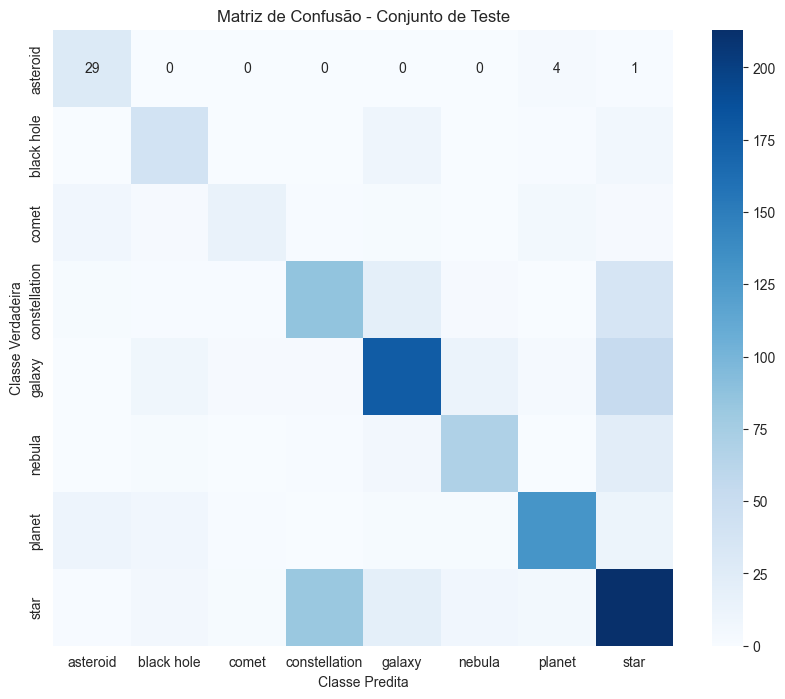

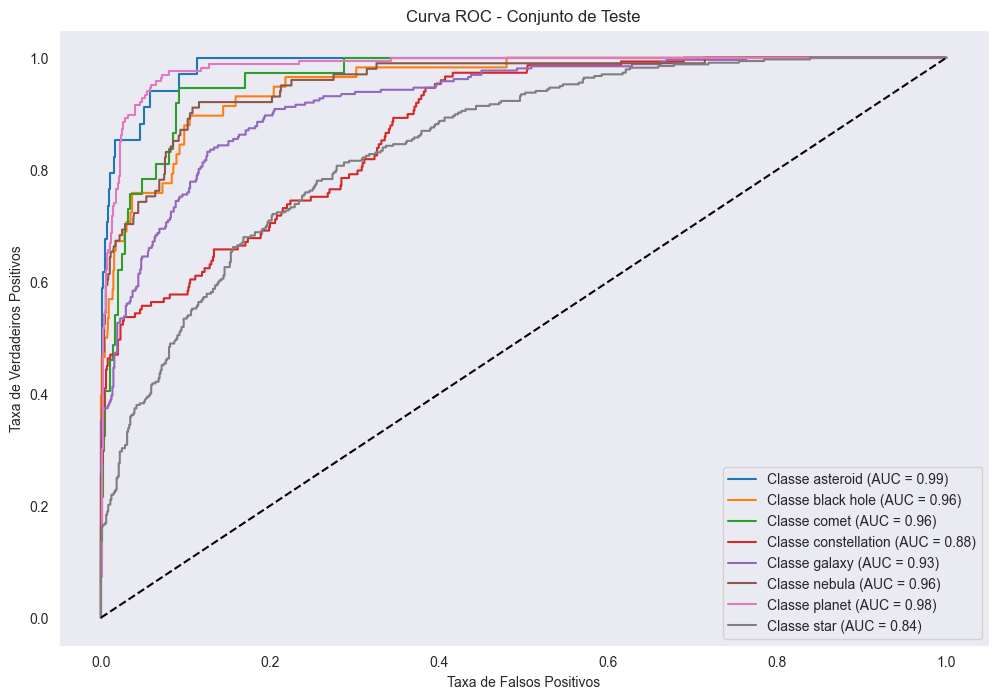

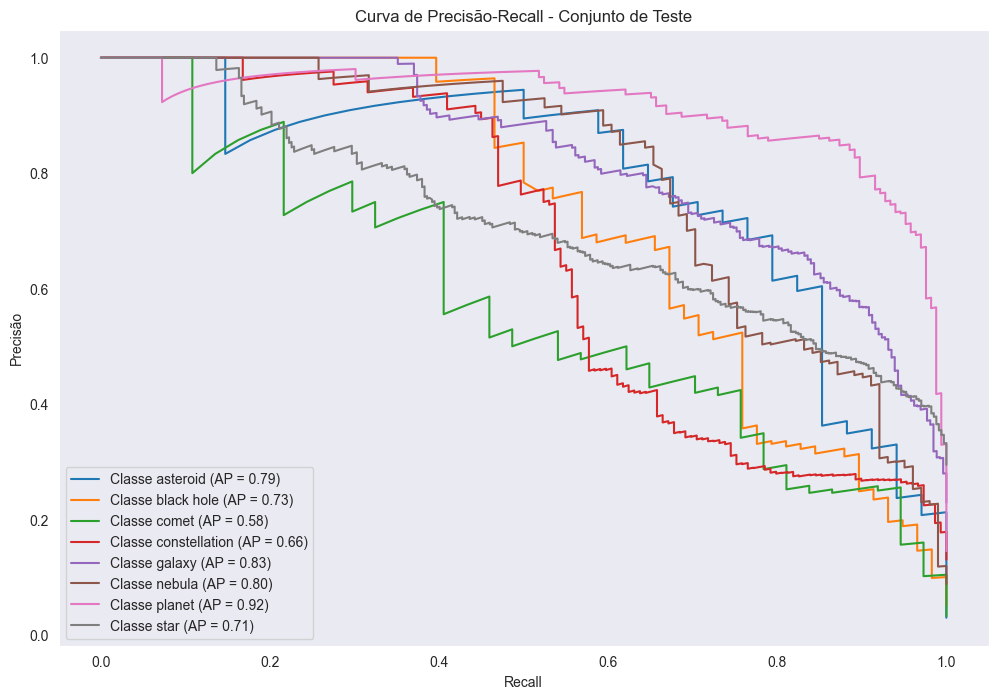

In [46]:
def evaluate_model(model, test_loader, dataset):
    """Função para avaliar o modelo no conjunto de teste com métricas detalhadas."""
    print("[INFO] Avaliando o modelo no conjunto de teste...")
    model.eval()
    y_true, y_pred, y_probs = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            probs = torch.softmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())

    # Calculando métricas
    test_accuracy = accuracy_score(y_true, y_pred)
    test_f1 = f1_score(y_true, y_pred, average='weighted')
    test_precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    test_recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    
    print(f"\n[TESTE] Acurácia: {test_accuracy:.4f}, F1-Score: {test_f1:.4f}, Precisão: {test_precision:.4f}, Recall: {test_recall:.4f}")

    # Relatório de Classificação
    report = classification_report(y_true, y_pred, target_names=dataset.classes, zero_division=0)
    print("\nRelatório de Classificação:\n", report)

    # Matriz de Confusão
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", 
                xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.title("Matriz de Confusão - Conjunto de Teste")
    plt.xlabel("Classe Predita")
    plt.ylabel("Classe Verdadeira")
    plt.show()

    # Gráfico ROC e Curva de Precisão-Recall para cada classe
    plot_roc_curve(y_true, y_probs, dataset.classes)
    plot_precision_recall_curve(y_true, y_probs, dataset.classes)


def plot_roc_curve(y_true, y_probs, class_names):
    """Plotar a curva ROC para cada classe."""
    from sklearn.metrics import roc_curve, auc
    n_classes = len(class_names)
    
    plt.figure(figsize=(12, 8))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve([1 if y == i else 0 for y in y_true], [y[i] for y in y_probs])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Classe {class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("Curva ROC - Conjunto de Teste")
    plt.xlabel("Taxa de Falsos Positivos")
    plt.ylabel("Taxa de Verdadeiros Positivos")
    plt.legend()
    plt.grid()
    plt.show()
def plot_precision_recall_curve(y_true, y_probs, class_names):
    """Plotar a curva de Precisão-Recall para cada classe."""
    from sklearn.metrics import precision_recall_curve, average_precision_score
    
    plt.figure(figsize=(12, 8))
    n_classes = len(class_names)

    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve([1 if y == i else 0 for y in y_true], [y[i] for y in y_probs])
        avg_precision = average_precision_score([1 if y == i else 0 for y in y_true], [y[i] for y in y_probs])
        plt.plot(recall, precision, label=f'Classe {class_names[i]} (AP = {avg_precision:.2f})')

    plt.title("Curva de Precisão-Recall - Conjunto de Teste")
    plt.xlabel("Recall")
    plt.ylabel("Precisão")
    plt.legend()
    plt.grid()
    plt.show()
    
# Avaliar o modelo no conjunto de teste
evaluate_model(model, test_loader, dataset)

---

## 13. Otimização de Hiperparâmetros com Optuna

Nesta etapa, o **Optuna** é utilizado para encontrar os melhores hiperparâmetros para o modelo. O processo envolve:
1. Definição de uma função objetivo para avaliar o desempenho do modelo.
2. Execução de múltiplos *trials* para explorar diferentes combinações de hiperparâmetros.
3. Identificação dos hiperparâmetros que minimizam a perda de validação.

---

## **Explicação do Código**

### **1. Função `objective`**
#### **Objetivo**
A função objetivo define como os *trials* serão avaliados. Cada *trial* sugere uma combinação de hiperparâmetros e avalia o modelo.

#### **Hiperparâmetros Sugeridos**
- **`hidden_units`**:
  ```python
  hidden_units = trial.suggest_int("hidden_units", 256, 1024, step=256)
  ```
  - Define o número de unidades na camada oculta, variando entre 256 e 1024.
- **`dropout_rate`**:
  ```python
  dropout_rate = trial.suggest_float("dropout_rate", 0.3, 0.5)
  ```
  - Taxa de dropout para regularização, variando entre 0.3 e 0.5.
- **`learning_rate`**:
  ```python
  learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
  ```
  - Taxa de aprendizado, explorada em escala logarítmica para maior cobertura.

#### **Processo**
1. Criação do modelo com os hiperparâmetros sugeridos.
2. Treinamento do modelo no conjunto de treino.
3. Validação do modelo no conjunto de validação, retornando a perda como métrica.

---

### **2. Função `run_optuna_optimization`**
#### **Objetivo**
Executar o processo de otimização com **Optuna**.

#### **Configuração**
```python
study = optuna.create_study(direction="minimize")
```
- **`direction="minimize"`**: Indica que a função objetivo deve ser minimizada (reduzir a perda de validação).

#### **Execução**
```python
study.optimize(objective, n_trials=2)
```
- **`objective`**: Função objetivo que será otimizada.
- **`n_trials=2`**: Número de *trials* a serem executados (ajustável).

#### **Resultado**
```python
print("[INFO] Melhores hiperparâmetros encontrados:", study.best_params)
```
- Exibe os melhores hiperparâmetros encontrados durante a otimização.

---

## **Saída**

### **Exemplo de Log**
```plaintext
[INFO] Iniciando otimização com Optuna...
[INFO] Iniciando o trial 0 para otimização...
[INFO] Iniciando o trial 1 para otimização...
[INFO] Melhores hiperparâmetros encontrados: {'hidden_units': 512, 'dropout_rate': 0.4, 'learning_rate': 0.0001}
```

---

## **Resumo**

### **Objetivo**
Explorar diferentes combinações de hiperparâmetros para encontrar a configuração que minimiza a perda de validação.

### **Benefícios**
- **Automação**: Optuna sugere automaticamente os valores para hiperparâmetros.
- **Eficiência**: Reduz o esforço manual de ajustar hiperparâmetros.

### **Próximos Passos**
- Treinar o modelo final utilizando os melhores hiperparâmetros encontrados.
- Avaliar o modelo no conjunto de teste para verificar o desempenho com a configuração otimizada.


In [47]:
def objective(trial):
    print(f"[INFO] Iniciando o trial {trial.number} para otimização...")
    # Sugerir valores para os hiperparâmetros
    hidden_units = trial.suggest_int("hidden_units", 256, 1024, step=256)
    dropout_rate = trial.suggest_float("dropout_rate", 0.3, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    # Criar o modelo com os hiperparâmetros sugeridos
    model = create_model(hidden_units=hidden_units, dropout_rate=dropout_rate)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # Treinar o modelo
    train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=3, patience=2)
    # Validar o modelo e obter a perda de validação
    val_loss, _, _ = validate_model(model, val_loader, criterion)
    return val_loss

def run_optuna_optimization():
    print("[INFO] Iniciando otimização com Optuna...")
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=2)
    print("[INFO] Melhores hiperparâmetros encontrados:", study.best_params)
    return study.best_params

# Executar a otimização
best_params = run_optuna_optimization()

[INFO] Iniciando otimização com Optuna...
[INFO] Iniciando o trial 0 para otimização...
[INFO] Criando o modelo ResNet18...
[INFO] Modelo criado.

[INFO] Iniciando o treinamento do modelo...

[ÉPOCA 1/3]


Treinando (Época 1/3): 100%|██████████| 251/251 [10:20<00:00,  2.47s/batch, Loss=0.9974]


[TREINO] Loss: 0.8986, Acurácia: 0.6755, F1-Score: 0.6710


Validando: 100%|██████████| 72/72 [02:49<00:00,  2.35s/batch, Loss=0.4101]


[VALIDAÇÃO] Loss: 0.7773, Acurácia: 0.7331, F1-Score: 0.7276, Precisão: 0.7657, Recall: 0.7331
[VALIDAÇÃO] Loss: 0.7773, Acurácia: 0.7331, F1-Score: 0.7276
[INFO] Melhor loss de validação encontrado. Salvando o modelo...

[ÉPOCA 2/3]


Treinando (Época 2/3): 100%|██████████| 251/251 [10:18<00:00,  2.46s/batch, Loss=0.3469]


[TREINO] Loss: 0.6636, Acurácia: 0.7520, F1-Score: 0.7497


Validando: 100%|██████████| 72/72 [02:49<00:00,  2.35s/batch, Loss=0.3972]


[VALIDAÇÃO] Loss: 0.7847, Acurácia: 0.7160, F1-Score: 0.7063, Precisão: 0.7359, Recall: 0.7160
[VALIDAÇÃO] Loss: 0.7847, Acurácia: 0.7160, F1-Score: 0.7063
[INFO] Patience counter: 1/2

[ÉPOCA 3/3]


Treinando (Época 3/3): 100%|██████████| 251/251 [10:23<00:00,  2.48s/batch, Loss=0.6275]


[TREINO] Loss: 0.5608, Acurácia: 0.7920, F1-Score: 0.7897


Validando: 100%|██████████| 72/72 [02:55<00:00,  2.44s/batch, Loss=0.4172]


[VALIDAÇÃO] Loss: 0.6826, Acurácia: 0.7457, F1-Score: 0.7403, Precisão: 0.7553, Recall: 0.7457
[VALIDAÇÃO] Loss: 0.6826, Acurácia: 0.7457, F1-Score: 0.7403
[INFO] Melhor loss de validação encontrado. Salvando o modelo...

[RESUMO DO TREINAMENTO]
Total de épocas realizadas: 3
Melhor época: 3
Melhor Loss de Validação: 0.6826
Acurácia de Treinamento na última época: 0.7920
Acurácia de Validação na última época: 0.7457
F1-Score de Treinamento na última época: 0.7897
F1-Score de Validação na última época: 0.7403
[INFO] Treinamento concluído.


Validando: 100%|██████████| 72/72 [02:47<00:00,  2.32s/batch, Loss=0.4172]


[VALIDAÇÃO] Loss: 0.6826, Acurácia: 0.7457, F1-Score: 0.7403, Precisão: 0.7553, Recall: 0.7457
[INFO] Iniciando o trial 1 para otimização...
[INFO] Criando o modelo ResNet18...
[INFO] Modelo criado.

[INFO] Iniciando o treinamento do modelo...

[ÉPOCA 1/3]


Treinando (Época 1/3): 100%|██████████| 251/251 [10:37<00:00,  2.54s/batch, Loss=0.4954]


[TREINO] Loss: 0.8662, Acurácia: 0.6821, F1-Score: 0.6777


Validando: 100%|██████████| 72/72 [02:48<00:00,  2.34s/batch, Loss=0.6269]


[VALIDAÇÃO] Loss: 0.7045, Acurácia: 0.7409, F1-Score: 0.7375, Precisão: 0.7504, Recall: 0.7409
[VALIDAÇÃO] Loss: 0.7045, Acurácia: 0.7409, F1-Score: 0.7375
[INFO] Melhor loss de validação encontrado. Salvando o modelo...

[ÉPOCA 2/3]


Treinando (Época 2/3): 100%|██████████| 251/251 [10:22<00:00,  2.48s/batch, Loss=0.5399]


[TREINO] Loss: 0.5945, Acurácia: 0.7727, F1-Score: 0.7708


Validando: 100%|██████████| 72/72 [02:54<00:00,  2.43s/batch, Loss=0.4413]


[VALIDAÇÃO] Loss: 0.6205, Acurácia: 0.7554, F1-Score: 0.7501, Precisão: 0.7640, Recall: 0.7554
[VALIDAÇÃO] Loss: 0.6205, Acurácia: 0.7554, F1-Score: 0.7501
[INFO] Melhor loss de validação encontrado. Salvando o modelo...

[ÉPOCA 3/3]


Treinando (Época 3/3): 100%|██████████| 251/251 [10:42<00:00,  2.56s/batch, Loss=0.5552]


[TREINO] Loss: 0.4869, Acurácia: 0.8126, F1-Score: 0.8112


Validando: 100%|██████████| 72/72 [02:52<00:00,  2.40s/batch, Loss=0.6265]


[VALIDAÇÃO] Loss: 0.7964, Acurácia: 0.7042, F1-Score: 0.7009, Precisão: 0.7225, Recall: 0.7042
[VALIDAÇÃO] Loss: 0.7964, Acurácia: 0.7042, F1-Score: 0.7009
[INFO] Patience counter: 1/2

[RESUMO DO TREINAMENTO]
Total de épocas realizadas: 3
Melhor época: 2
Melhor Loss de Validação: 0.6205
Acurácia de Treinamento na última época: 0.8126
Acurácia de Validação na última época: 0.7042
F1-Score de Treinamento na última época: 0.8112
F1-Score de Validação na última época: 0.7009
[INFO] Treinamento concluído.


Validando: 100%|██████████| 72/72 [02:50<00:00,  2.37s/batch, Loss=0.6265]

[VALIDAÇÃO] Loss: 0.7964, Acurácia: 0.7042, F1-Score: 0.7009, Precisão: 0.7225, Recall: 0.7042
[INFO] Melhores hiperparâmetros encontrados: {'hidden_units': 1024, 'dropout_rate': 0.4362066658343654, 'learning_rate': 0.0003441088507003878}


---

## 14. Conclusão

Neste notebook, percorremos todas as etapas para construir um modelo de classificação de imagens astronômicas usando CNNs. Desde o pré-processamento dos dados até a otimização de hiperparâmetros, cobrimos técnicas importantes para melhorar o desempenho do modelo. Usamos o TQDM para melhorar a visualização do progresso durante o treinamento e validação, tornando o processo mais interativo e informativo.

---